In [2]:
D.<x> = PolynomialRing(QQ)
R = PolynomialRing(QQ,'x')
S = PowerSeriesRing(QQ,'x', default_prec=300)
L=LaurentSeriesRing(QQ,'x', default_prec=300)
#S.<x,y>=PowerSeriesRing(QQ,default_prec=300)
# Using "R = PolynomialRing(QQ,'x')" produces an error.
# Yet using S as defined here is fine (see definition of Fraleigh4 below)
# But S = PowerSeriesRing(QQ,'x','y') also produces an error.
Scplx= PowerSeriesRing(CC,'x',default_prec=300)
def pochhammer(x,n):
    return product ([x+k for k in [0..n-1]])
def cRaleigh2(alpha,beta,nu):
    pchhmrA = pochhammer(alpha,nu)
    pchhmrB = pochhammer(beta,nu)
    fnu=factorial(nu)
    answer = D(pchhmrA*pchhmrB/fnu^2)
    return answer
def term(alpha,beta,p):
    return D(1/(alpha + p) + 1/(beta + p) - 2/(1 + p))
def eRaleigh(alpha, beta, nu):
    return D(sum([term(alpha, beta, p) for p in [0..nu - 1]]))
def FstarRaleigh2(alpha,beta,u,terms):
    fsr = sum([cRaleigh2(alpha, beta, nu)*eRaleigh(alpha,beta,nu)*u^nu for nu in [1..terms]])
    return D(fsr)
def Fraleigh2(alpha,beta,u,terms): 
    return D(sum([cRaleigh2(alpha,beta,nu)*u^nu for nu in [0..terms]]))
def FstarRaleigh3(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fsr2 = FstarRaleigh2(alpha,beta,x,n)
    return D(fsr2)
def Fraleigh4(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fr2 = Fraleigh2(alpha,beta,x,n)
    return D(fr2)
def exNo3c(n,m):
    a1 = S(x)*exp(S(FstarRaleigh3(n,m,x)/Fraleigh4(n,m,x))).O(2*n)
    # S(x) instead of x in df of a1 to avoid an error message
    # after use of the stripQuotationMarks command below.
    a2 = S(a1).O(n+1)
    return a2 # applying S to argument of exp is key.
def J(n,m):
    exn = exNo3c(n+2,m)
    jnm = 1/exn.reverse()
    return jnm.O(n+1) # Jtest is faster than J, and they agree.
def normalJ(n,m):
    f = J(n,m)
    return f.truncate(n+1)
def Jcoefficient(n,m):
    f = J(n+2,m)
    f1 = f.truncate(n+1)
    f1=f1.list()
    f1=Set(f1)
    g1 = f.truncate(n)
    g1 = g1.list()
    g1 = set(g1)
    h = f1.difference(g1)
    h = h.list()
    return h[0]
def xjNewStep(n,m): 
    f=J(n,m)
    fl=f.list()
    return (sum(c*x**i*(m**3*2**6)**i for i,c in enumerate(fl)))
def xjNew(n,m):
    return xjNewStep(n-1,m)
def xjNewCoefficient(n,m):
    if n>0:return (xjNew(n,m)-xjNew(n-1,m))/x^n
    if n==0:return 1
def xjNewTest(n,m):
    return D(xjNewStep(n-1,m))
def j(n,m):return xjNew(n,m)/x

def H4(n,m): # this is the definition in the published interpolations paper (2021):
    # def. 8.4
    jay=J(n+1,m)
    djay=x*derivative(jay,x) # bc variable is tau, not x; chain rule.
    numerator = djay^2
    denominator = jay*(jay-1)
    return ((S(numerator/denominator)^(1/(m-2))).O(n+1)).polynomial()
    #if argument is an S type then 'polynomial' takes no argument.

def H4strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=H4(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [0..polydegree])
    return answer


def H6(n,m):
    def base6(n,m):
        jay=J(n+1,m)
        num=(x*derivative(jay,x))^m # chain rule; variable is tau not x.
        den = expand(jay^(m-1)*(jay-1))
        return L((-1)^m*(num/den)).O(n+1)
    return S(base6(n,m)^(1/(m-2))).polynomial()
     #if argument is an S type then 'polynomial' takes no argument.

def H6strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=H6(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [0..polydegree])
    return answer

def polynomialCoefficient(n,poly):
    return poly.list()[n]
def factorpairToFactor(factorpair):
    (monomial,exponent)=factorpair
    return monomial^exponent
def numericalfactor(polynomial):
    fp=polynomial.factor()
    lst=[factorpairToFactor(factorpair) for factorpair in fp]
    return polynomial/product(lst)
def lastfactor(polynomial):
    fp=polynomial.factor()
    fp=FiniteEnumeratedSet(fp)
    return factorpairToFactor(fp.last())
def reduced(polynomial):
    return numericalfactor(polynomial)*lastfactor(polynomial)
def stripQuotationMarks(string):
    var('x')
    return sage_eval(string,locals={'x':x})
def nieburTau(n):
# The contortions below sidestep mysterious (to me) error messages...
# nieburTau is an algorith for Ramanujan''s tau from the paper
# "A formula for Ramanujan's tau-function" by Douglas Niebur.
# (He spells tau with the Greek letter.)
    def step1(n,k):
        return 35*k^4-52*k^3*n+18*k^2*n^2
    def step2(n,k):
        return sigma(k)*sigma(n-k)
    def step3(n):
        ans=0
        for k in [1..n-1]:
            ans=ans+step1(n,k)*step2(n,k)
        return 24*ans
    return n^4*sigma(n)-step3(n)

def deltaDagger(n,m):
    def ddstep1(n,m):
        return D(S(expand((H4(n+2,m)^3)))).truncate(n+1)
    def ddstep2(n,m):
        return D(S((H6(n+2,m)^2))).truncate(n+1)
    return ((ddstep1(n,m)-ddstep2(n,m))/1728)

def deltaDaggerStrike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=deltaDagger(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    return answer

def deltaDagger2(n,m):
    def ddstep1(n,m):
        return D(S(expand((H4(n+2,m)^3)))).truncate(n+1)
    def ddstep2(n,m):
        return D(S((H6(n+2,m)^2))).truncate(n+1)
    return (ddstep1(n,m)-ddstep2(n,m))

# def deltaDaggerStrike(n,m):
 #   return S(((H4strike(n,3)^3-H6strike(n,3)^2)/1728)).truncate(n+1)
    
def deltaDagger2Strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=deltaDagger2(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    return answer

def first(list):return list[0]
def last(list):return list[-1]

def rmnjntau(n):
    answer=0
    for k in [1..n-1]:
        answer=answer+(6*k-4*(n-k))*sigma(k,3)*sigma(n-k,5)
    answer=(5*sigma(n,3)+7*sigma(n,5))*n/12-35*answer
    return answer

def element(k,listo):
    if k>len(listo):return (print("bad k"))
    return listo[k-1]

def mobiusInverseOfFunction(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        f=f+moebius(dvk)*g(n/dvk)
    return f

def mobiusInverseOfList(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        gndvk=element(n/dvk,g)
        f=f+moebius(dvk)*gndvk
    return f

def drop_first_element(listo):
    lenth=len(listo)
    answer=[]
    for k in [1..lenth-1]:
        answer=answer+[listo[k]]
    return answer

def factorSeriesFromLists(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
    return nswr

def factorSeriesFromListsWithTracking(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
            print((n,k))
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
        print("answer length: ",len(nswr))
    return nswr



print("ok")

ok


In [ ]:
#from 'very long H4 12sept22', Output snipped.

data=[]
import time
start=time.time()/60
for m in [3..1203]:
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no6.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [1204..2403]:
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no7.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [2404..3610]:
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no9.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [3611..4818]:
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no10.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [ ]:
#from 'very long H6 12sept22', Output snipped.

data=[]
import time
start=time.time()/60
for m in [3..1203]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no5.txt','wb') # H6 series
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [1204..2403]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no8.txt','wb') # H6 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [2404..3610]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no11.txt','wb') # H6 series
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [3611..4818]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no12.txt','wb') # H6 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [2]:
# this failed so I do it again.
data=[]
import time
start=time.time()/60
for m in [3611..4818]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no12.txt','wb') # H6 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

[3611, 100, 0.06951621547341347]
[3612, 100, 0.1343885026872158]
[3613, 100, 0.19917024672031403]
[3614, 100, 0.25312186405062675]
[3615, 100, 0.32509221509099007]
[3616, 100, 0.38267598301172256]
[3617, 100, 0.44895341992378235]
[3618, 100, 0.5041163824498653]
[3619, 100, 0.5714646317064762]
[3620, 100, 0.6314492151141167]
[3621, 100, 0.6997157856822014]
[3622, 100, 0.7527280002832413]
[3623, 100, 0.819094818085432]
[3624, 100, 0.8832829631865025]
[3625, 100, 0.9543428681790829]
[3626, 100, 1.0127990134060383]
[3627, 100, 1.0844817832112312]
[3628, 100, 1.1456120647490025]
[3629, 100, 1.2125556208193302]
[3630, 100, 1.2718616649508476]
[3631, 100, 1.3381785824894905]
[3632, 100, 1.3968661837279797]
[3633, 100, 1.4686950333416462]
[3634, 100, 1.5223757810890675]
[3635, 100, 1.5923317670822144]
[3636, 100, 1.6562524512410164]
[3637, 100, 1.7231220789253712]
[3638, 100, 1.7787899039685726]
[3639, 100, 1.8498201817274094]
[3640, 100, 1.9141732826828957]
[3641, 100, 1.9825565963983536]
[36

[3872, 100, 17.04557280242443]
[3873, 100, 17.114686783403158]
[3874, 100, 17.17037545144558]
[3875, 100, 17.239514000713825]
[3876, 100, 17.305885333567858]
[3877, 100, 17.371608797460794]
[3878, 100, 17.428873497992754]
[3879, 100, 17.4986090362072]
[3880, 100, 17.56293808296323]
[3881, 100, 17.630055498331785]
[3882, 100, 17.688163049519062]
[3883, 100, 17.756515979766846]
[3884, 100, 17.818202186375856]
[3885, 100, 17.893401581794024]
[3886, 100, 17.949702832847834]
[3887, 100, 18.02081212028861]
[3888, 100, 18.08482688292861]
[3889, 100, 18.153643518686295]
[3890, 100, 18.209845781326294]
[3891, 100, 18.28090028464794]
[3892, 100, 18.34492476284504]
[3893, 100, 18.413220819085836]
[3894, 100, 18.472357228398323]
[3895, 100, 18.544239670038223]
[3896, 100, 18.606194850057364]
[3897, 100, 18.67650956660509]
[3898, 100, 18.732784166932106]
[3899, 100, 18.80227941647172]
[3900, 100, 18.871332816779613]
[3901, 100, 18.93898979946971]
[3902, 100, 18.994672052562237]
[3903, 100, 19.06547

[4132, 100, 33.93645329773426]
[4133, 100, 34.00393843278289]
[4134, 100, 34.06349616497755]
[4135, 100, 34.13206806778908]
[4136, 100, 34.194684501737356]
[4137, 100, 34.26615174487233]
[4138, 100, 34.32184126973152]
[4139, 100, 34.390702083706856]
[4140, 100, 34.45904836803675]
[4141, 100, 34.52851101756096]
[4142, 100, 34.584541615098715]
[4143, 100, 34.65544741600752]
[4144, 100, 34.71647021919489]
[4145, 100, 34.78582498431206]
[4146, 100, 34.84283170476556]
[4147, 100, 34.911926217377186]
[4148, 100, 34.97517195343971]
[4149, 100, 35.04613018408418]
[4150, 100, 35.10453151538968]
[4151, 100, 35.173237301409245]
[4152, 100, 35.23639168217778]
[4153, 100, 35.30279700085521]
[4154, 100, 35.35730656608939]
[4155, 100, 35.429687302559614]
[4156, 100, 35.49016783386469]
[4157, 100, 35.557283133268356]
[4158, 100, 35.61786727979779]
[4159, 100, 35.68535973131657]
[4160, 100, 35.74600053206086]
[4161, 100, 35.81654058396816]
[4162, 100, 35.87119226530194]
[4163, 100, 35.93861384689808]
[

[4395, 100, 50.93462798371911]
[4396, 100, 50.9955975972116]
[4397, 100, 51.06072496622801]
[4398, 100, 51.11688978224993]
[4399, 100, 51.18377463519573]
[4400, 100, 51.24644123390317]
[4401, 100, 51.31521200016141]
[4402, 100, 51.369268115609884]
[4403, 100, 51.437395330518484]
[4404, 100, 51.50006276741624]
[4405, 100, 51.568264201283455]
[4406, 100, 51.620659936219454]
[4407, 100, 51.6905365511775]
[4408, 100, 51.75080220028758]
[4409, 100, 51.81807807087898]
[4410, 100, 51.87881004810333]
[4411, 100, 51.9476099871099]
[4412, 100, 52.008718367666006]
[4413, 100, 52.07910093292594]
[4414, 100, 52.13443526625633]
[4415, 100, 52.20308706536889]
[4416, 100, 52.263742331415415]
[4417, 100, 52.33195533230901]
[4418, 100, 52.387055303901434]
[4419, 100, 52.45533004775643]
[4420, 100, 52.52063746377826]
[4421, 100, 52.58636113628745]
[4422, 100, 52.644403997808695]
[4423, 100, 52.70958901569247]
[4424, 100, 52.771085035055876]
[4425, 100, 52.8424139469862]
[4426, 100, 52.89659841731191]
[44

[4659, 100, 67.9946040995419]
[4660, 100, 68.05776718258858]
[4661, 100, 68.12469093129039]
[4662, 100, 68.18418595194817]
[4663, 100, 68.25146149843931]
[4664, 100, 68.31400406733155]
[4665, 100, 68.3865179978311]
[4666, 100, 68.44181495159864]
[4667, 100, 68.50987876579165]
[4668, 100, 68.57438758388162]
[4669, 100, 68.6432970315218]
[4670, 100, 68.70131116732955]
[4671, 100, 68.77021446451545]
[4672, 100, 68.82884410023689]
[4673, 100, 68.89400901272893]
[4674, 100, 68.9524695314467]
[4675, 100, 69.02336340025067]
[4676, 100, 69.08648901432753]
[4677, 100, 69.1560373865068]
[4678, 100, 69.21048754826188]
[4679, 100, 69.27771366760135]
[4680, 100, 69.34448241442442]
[4681, 100, 69.41188655048609]
[4682, 100, 69.46621049940586]
[4683, 100, 69.53796358406544]
[4684, 100, 69.5995465517044]
[4685, 100, 69.66778291389346]
[4686, 100, 69.72722238302231]
[4687, 100, 69.79402916878462]
[4688, 100, 69.85449833422899]
[4689, 100, 69.92444974929094]
[4690, 100, 69.98424063250422]
[4691, 100, 70

In [14]:
import pickle
r41 = open('/Users/barrybrent/12sept22no6.txt','rb')  # H4 series 
rs41=pickle.load(r41)
r41.close()
s41=stripQuotationMarks(rs41)

r61 = open('/Users/barrybrent/12sept22no5.txt','rb') # H6 series
rs61=pickle.load(r61)
r61.close()
s61=stripQuotationMarks(rs61)


import time
w1 = open('/Users/barrybrent/13sept22no1.txt','wb') # test deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..3]:
    start = time.time()
    m=s41[n][0]
    h6squared=s61[n][1]^2
    h4cubed=s41[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
    print(answer)
t = pickle.dumps(str(data))
w1.write(t)
w1.close()
print(len(s41),len(s61))

[3, 99, 0.02786421775817871]
-104984487099648*x^99 + 70376541064704*x^98 + 129623446447488*x^97 - 85656940314624*x^96 + 88982770060800*x^95 - 111449716826112*x^94 - 23010874564608*x^93 - 47421324951552*x^92 + 16716058684416*x^91 + 22763802055680*x^90 - 43187760766080*x^89 + 78043429601280*x^88 + 55915437473280*x^87 + 710237362176*x^86 - 57638582588160*x^85 + 10732757188608*x^84 - 50691052226304*x^83 - 12778370970624*x^82 + 2877445487808*x^81 + 8238873968640*x^80 + 65865909335040*x^79 + 6037907484672*x^78 - 15468266870784*x^77 - 27118558494720*x^76 - 11103790521600*x^75 + 7556750558208*x^74 + 2529431404416*x^73 - 16589768785920*x^72 + 16919686550016*x^71 + 3353986621440*x^70 + 8118324652032*x^69 + 17566044217344*x^68 - 26752596855552*x^67 - 5587200073728*x^66 - 4821940005120*x^65 + 4664384815104*x^64 + 3288104741376*x^63 + 2191511863296*x^62 + 12020795127936*x^61 - 3095987650560*x^60 - 8966944062720*x^59 - 5325279759360*x^58 + 4642579307520*x^57 - 2444313231360*x^56 + 4462000058880*x^55

In [16]:
import pickle
r41 = open('/Users/barrybrent/12sept22no6.txt','rb')  # H4 series 
rs41=pickle.load(r41)
r41.close()
s41=stripQuotationMarks(rs41)

r61 = open('/Users/barrybrent/12sept22no5.txt','rb') # H6 series
rs61=pickle.load(r61)
r61.close()
s61=stripQuotationMarks(rs61)


import time
w1 = open('/Users/barrybrent/13sept22no2.txt','wb') # 1st deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1200]:
    start = time.time()
    m=s41[n][0]
    h6squared=s61[n][1]^2
    h4cubed=s41[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()
print(len(t))

[3, 99, 0.027976036071777344]
[4, 99, 0.028879880905151367]
[5, 99, 0.03371691703796387]
[6, 99, 0.021645784378051758]
[7, 99, 0.034126996994018555]
[8, 99, 0.03178524971008301]
[9, 99, 0.034687042236328125]
[10, 99, 0.034661054611206055]
[11, 99, 0.03485298156738281]
[12, 99, 0.03474926948547363]
[13, 99, 0.03558206558227539]
[14, 99, 0.03686213493347168]
[15, 99, 0.03617215156555176]
[16, 99, 0.03249382972717285]
[17, 99, 0.03501391410827637]
[18, 99, 0.03301811218261719]
[19, 99, 0.037374019622802734]
[20, 99, 0.034275054931640625]
[21, 99, 0.03539896011352539]
[22, 99, 0.03285098075866699]
[23, 99, 0.035043954849243164]
[24, 99, 0.03403067588806152]
[25, 99, 0.035531044006347656]
[26, 99, 0.035221099853515625]
[27, 99, 0.035897254943847656]
[28, 99, 0.03429985046386719]
[29, 99, 0.03491806983947754]
[30, 99, 0.0324859619140625]
[31, 99, 0.03594493865966797]
[32, 99, 0.03326106071472168]
[33, 99, 0.04490184783935547]
[34, 99, 0.03487515449523926]
[35, 99, 0.03725910186767578]
[36, 9

[269, 99, 0.040979862213134766]
[270, 99, 0.03870081901550293]
[271, 99, 0.04066610336303711]
[272, 99, 0.03860592842102051]
[273, 99, 0.04529714584350586]
[274, 99, 0.03686785697937012]
[275, 99, 0.04325294494628906]
[276, 99, 0.041391849517822266]
[277, 99, 0.039990901947021484]
[278, 99, 0.0355229377746582]
[279, 99, 0.04000282287597656]
[280, 99, 0.04073190689086914]
[281, 99, 0.040021419525146484]
[282, 99, 0.03844475746154785]
[283, 99, 0.04284310340881348]
[284, 99, 0.039144039154052734]
[285, 99, 0.04419517517089844]
[286, 99, 0.03713703155517578]
[287, 99, 0.04492807388305664]
[288, 99, 0.04017996788024902]
[289, 99, 0.04453015327453613]
[290, 99, 0.0387730598449707]
[291, 99, 0.04168415069580078]
[292, 99, 0.037825822830200195]
[293, 99, 0.040656089782714844]
[294, 99, 0.03809785842895508]
[295, 99, 0.0422511100769043]
[296, 99, 0.03960609436035156]
[297, 99, 0.04267287254333496]
[298, 99, 0.03629302978515625]
[299, 99, 0.040801048278808594]
[300, 99, 0.03969717025756836]
[30

[537, 99, 0.04299807548522949]
[538, 99, 0.037438154220581055]
[539, 99, 0.04640507698059082]
[540, 99, 0.04457974433898926]
[541, 99, 0.043950796127319336]
[542, 99, 0.037322998046875]
[543, 99, 0.044210195541381836]
[544, 99, 0.037901878356933594]
[545, 99, 0.04621481895446777]
[546, 99, 0.040693044662475586]
[547, 99, 0.04315757751464844]
[548, 99, 0.041768789291381836]
[549, 99, 0.043486833572387695]
[550, 99, 0.038172006607055664]
[551, 99, 0.045990943908691406]
[552, 99, 0.0404360294342041]
[553, 99, 0.04435110092163086]
[554, 99, 0.039263010025024414]
[555, 99, 0.0438840389251709]
[556, 99, 0.03815293312072754]
[557, 99, 0.046469926834106445]
[558, 99, 0.037978172302246094]
[559, 99, 0.04280400276184082]
[560, 99, 0.04169297218322754]
[561, 99, 0.04355287551879883]
[562, 99, 0.0379948616027832]
[563, 99, 0.04569602012634277]
[564, 99, 0.04325699806213379]
[565, 99, 0.04424595832824707]
[566, 99, 0.03844189643859863]
[567, 99, 0.04557013511657715]
[568, 99, 0.03970599174499512]
[

[801, 99, 0.044033050537109375]
[802, 99, 0.039144039154052734]
[803, 99, 0.04559016227722168]
[804, 99, 0.04381990432739258]
[805, 99, 0.044905900955200195]
[806, 99, 0.03949737548828125]
[807, 99, 0.04501700401306152]
[808, 99, 0.04026222229003906]
[809, 99, 0.04724407196044922]
[810, 99, 0.040689945220947266]
[811, 99, 0.044519901275634766]
[812, 99, 0.04274487495422363]
[813, 99, 0.043639183044433594]
[814, 99, 0.03857088088989258]
[815, 99, 0.0464479923248291]
[816, 99, 0.04285597801208496]
[817, 99, 0.04338788986206055]
[818, 99, 0.04157114028930664]
[819, 99, 0.04392814636230469]
[820, 99, 0.04236626625061035]
[821, 99, 0.045928239822387695]
[822, 99, 0.03989291191101074]
[823, 99, 0.04291701316833496]
[824, 99, 0.04397296905517578]
[825, 99, 0.04427814483642578]
[826, 99, 0.03957796096801758]
[827, 99, 0.046424150466918945]
[828, 99, 0.04282498359680176]
[829, 99, 0.0463869571685791]
[830, 99, 0.03985404968261719]
[831, 99, 0.04623723030090332]
[832, 99, 0.04429292678833008]
[8

[1067, 99, 0.04425811767578125]
[1068, 99, 0.043152809143066406]
[1069, 99, 0.0474238395690918]
[1070, 99, 0.03916001319885254]
[1071, 99, 0.045500993728637695]
[1072, 99, 0.042481184005737305]
[1073, 99, 0.0439908504486084]
[1074, 99, 0.040040016174316406]
[1075, 99, 0.04971599578857422]
[1076, 99, 0.04239201545715332]
[1077, 99, 0.04310131072998047]
[1078, 99, 0.0390777587890625]
[1079, 99, 0.04467892646789551]
[1080, 99, 0.042836904525756836]
[1081, 99, 0.04670381546020508]
[1082, 99, 0.03962993621826172]
[1083, 99, 0.04525494575500488]
[1084, 99, 0.04083895683288574]
[1085, 99, 0.04448699951171875]
[1086, 99, 0.03814387321472168]
[1087, 99, 0.04817008972167969]
[1088, 99, 0.04223012924194336]
[1089, 99, 0.04604697227478027]
[1090, 99, 0.03979992866516113]
[1091, 99, 0.04299807548522949]
[1092, 99, 0.043125152587890625]
[1093, 99, 0.04600024223327637]
[1094, 99, 0.03967595100402832]
[1095, 99, 0.04527401924133301]
[1096, 99, 0.0399169921875]
[1097, 99, 0.04520869255065918]
[1098, 99

In [3]:
import pickle
rfile =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))

1201


In [8]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1) 
r1.close()
s1=stripQuotationMarks(r1s)
data1=[]
bound=99
def m(n):return s1[n][0]
def pre_g(n):return s1[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..1200]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    em=m(index)
    data1=data1+[[em,fs]]
    print(em,len(fs))

# interpolating polynomials
w1 =  open('/Users/barrybrent/15sept22no3.txt','wb') #1st deltaDagger2 exponents
t1 = pickle.dumps(str(data1))
w1.write(t1)
w1.close()

3 98
4 98
5 98
6 98
7 98
8 98
9 98
10 98
11 98
12 98
13 98
14 98
15 98
16 98
17 98
18 98
19 98
20 98
21 98
22 98
23 98
24 98
25 98
26 98
27 98
28 98
29 98
30 98
31 98
32 98
33 98
34 98
35 98
36 98
37 98
38 98
39 98
40 98
41 98
42 98
43 98
44 98
45 98
46 98
47 98
48 98
49 98
50 98
51 98
52 98
53 98
54 98
55 98
56 98
57 98
58 98
59 98
60 98
61 98
62 98
63 98
64 98
65 98
66 98
67 98
68 98
69 98
70 98
71 98
72 98
73 98
74 98
75 98
76 98
77 98
78 98
79 98
80 98
81 98
82 98
83 98
84 98
85 98
86 98
87 98
88 98
89 98
90 98
91 98
92 98
93 98
94 98
95 98
96 98
97 98
98 98
99 98
100 98
101 98
102 98
103 98
104 98
105 98
106 98
107 98
108 98
109 98
110 98
111 98
112 98
113 98
114 98
115 98
116 98
117 98
118 98
119 98
120 98
121 98
122 98
123 98
124 98
125 98
126 98
127 98
128 98
129 98
130 98
131 98
132 98
133 98
134 98
135 98
136 98
137 98
138 98
139 98
140 98
141 98
142 98
143 98
144 98
145 98
146 98
147 98
148 98
149 98
150 98
151 98
152 98
153 98
154 98
155 98
156 98
157 98
158 98
159 98
160 9

1167 98
1168 98
1169 98
1170 98
1171 98
1172 98
1173 98
1174 98
1175 98
1176 98
1177 98
1178 98
1179 98
1180 98
1181 98
1182 98
1183 98
1184 98
1185 98
1186 98
1187 98
1188 98
1189 98
1190 98
1191 98
1192 98
1193 98
1194 98
1195 98
1196 98
1197 98
1198 98
1199 98
1200 98
1201 98
1202 98
1203 98


In [2]:
import pickle
r42 = open('/Users/barrybrent/12sept22no7.txt','rb') # H4 series 
rs42=pickle.load(r42)
r42.close()
s42=stripQuotationMarks(rs42)

r62 = open('/Users/barrybrent/12sept22no8.txt','rb') # H6 series 
rs62=pickle.load(r62)
r62.close()
s62=stripQuotationMarks(rs62)

print((len(s42),len(s62)))

(1200, 1200)


In [3]:
import pickle
r42 = open('/Users/barrybrent/12sept22no7.txt','rb') # H4 series 
rs42=pickle.load(r42)
r42.close()
s42=stripQuotationMarks(rs42)

r62 = open('/Users/barrybrent/12sept22no8.txt','rb') # H6 series 
rs62=pickle.load(r62)
r62.close()
s62=stripQuotationMarks(rs62)


import time
w1 = open('/Users/barrybrent/14sept22no1.txt','wb') # 2nd deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1199]:
    start = time.time()
    m=s42[n][0]
    h6squared=s62[n][1]^2
    h4cubed=s42[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()
print(len(t))

[1204, 99, 0.5970890522003174]
[1205, 99, 0.04682493209838867]
[1206, 99, 0.04174470901489258]
[1207, 99, 0.0463259220123291]
[1208, 99, 0.044229745864868164]
[1209, 99, 0.047277212142944336]
[1210, 99, 0.04492592811584473]
[1211, 99, 0.04647207260131836]
[1212, 99, 0.04474616050720215]
[1213, 99, 0.04508781433105469]
[1214, 99, 0.04117918014526367]
[1215, 99, 0.0477910041809082]
[1216, 99, 0.04503822326660156]
[1217, 99, 0.045453786849975586]
[1218, 99, 0.04233503341674805]
[1219, 99, 0.04470038414001465]
[1220, 99, 0.04568195343017578]
[1221, 99, 0.04741978645324707]
[1222, 99, 0.04005026817321777]
[1223, 99, 0.04544782638549805]
[1224, 99, 0.0455322265625]
[1225, 99, 0.04514598846435547]
[1226, 99, 0.04303479194641113]
[1227, 99, 0.04581809043884277]
[1228, 99, 0.044587135314941406]
[1229, 99, 0.04608893394470215]
[1230, 99, 0.042389869689941406]
[1231, 99, 0.04475522041320801]
[1232, 99, 0.0458071231842041]
[1233, 99, 0.04734206199645996]
[1234, 99, 0.04127383232116699]
[1235, 99, 

[1464, 99, 0.04236602783203125]
[1465, 99, 0.04436683654785156]
[1466, 99, 0.04472088813781738]
[1467, 99, 0.04760909080505371]
[1468, 99, 0.04402518272399902]
[1469, 99, 0.04490089416503906]
[1470, 99, 0.043585777282714844]
[1471, 99, 0.04418587684631348]
[1472, 99, 0.0443882942199707]
[1473, 99, 0.04602384567260742]
[1474, 99, 0.04031109809875488]
[1475, 99, 0.04446697235107422]
[1476, 99, 0.043196916580200195]
[1477, 99, 0.04427599906921387]
[1478, 99, 0.041352033615112305]
[1479, 99, 0.04407811164855957]
[1480, 99, 0.043550968170166016]
[1481, 99, 0.045114755630493164]
[1482, 99, 0.04467511177062988]
[1483, 99, 0.04361104965209961]
[1484, 99, 0.04720187187194824]
[1485, 99, 0.04461026191711426]
[1486, 99, 0.03979301452636719]
[1487, 99, 0.043730974197387695]
[1488, 99, 0.04422593116760254]
[1489, 99, 0.04338502883911133]
[1490, 99, 0.044129133224487305]
[1491, 99, 0.045675039291381836]
[1492, 99, 0.044739723205566406]
[1493, 99, 0.044265031814575195]
[1494, 99, 0.039978981018066406

[1721, 99, 0.043100833892822266]
[1722, 99, 0.04372096061706543]
[1723, 99, 0.0447840690612793]
[1724, 99, 0.04407000541687012]
[1725, 99, 0.04589509963989258]
[1726, 99, 0.0391240119934082]
[1727, 99, 0.046766042709350586]
[1728, 99, 0.042471885681152344]
[1729, 99, 0.0471651554107666]
[1730, 99, 0.04067206382751465]
[1731, 99, 0.04499983787536621]
[1732, 99, 0.043025970458984375]
[1733, 99, 0.044737815856933594]
[1734, 99, 0.041216135025024414]
[1735, 99, 0.04743790626525879]
[1736, 99, 0.04242110252380371]
[1737, 99, 0.044137001037597656]
[1738, 99, 0.040244102478027344]
[1739, 99, 0.044548749923706055]
[1740, 99, 0.045797109603881836]
[1741, 99, 0.04548192024230957]
[1742, 99, 0.040077924728393555]
[1743, 99, 0.04442286491394043]
[1744, 99, 0.041925907135009766]
[1745, 99, 0.044873952865600586]
[1746, 99, 0.04410195350646973]
[1747, 99, 0.044113874435424805]
[1748, 99, 0.04240894317626953]
[1749, 99, 0.0458979606628418]
[1750, 99, 0.0395052433013916]
[1751, 99, 0.04450678825378418]

[1979, 99, 0.044580936431884766]
[1980, 99, 0.04497194290161133]
[1981, 99, 0.04689526557922363]
[1982, 99, 0.04127001762390137]
[1983, 99, 0.04630708694458008]
[1984, 99, 0.04162478446960449]
[1985, 99, 0.0450592041015625]
[1986, 99, 0.042791128158569336]
[1987, 99, 0.044645071029663086]
[1988, 99, 0.043502092361450195]
[1989, 99, 0.04581499099731445]
[1990, 99, 0.04100298881530762]
[1991, 99, 0.04690408706665039]
[1992, 99, 0.045661211013793945]
[1993, 99, 0.04635310173034668]
[1994, 99, 0.04111003875732422]
[1995, 99, 0.045441627502441406]
[1996, 99, 0.04251909255981445]
[1997, 99, 0.04597973823547363]
[1998, 99, 0.039929866790771484]
[1999, 99, 0.04604291915893555]
[2000, 99, 0.04219818115234375]
[2001, 99, 0.04451727867126465]
[2002, 99, 0.04435586929321289]
[2003, 99, 0.047089338302612305]
[2004, 99, 0.04392194747924805]
[2005, 99, 0.046502113342285156]
[2006, 99, 0.0399320125579834]
[2007, 99, 0.04444575309753418]
[2008, 99, 0.04563498497009277]
[2009, 99, 0.044725894927978516]


[2234, 99, 0.04025673866271973]
[2235, 99, 0.045091867446899414]
[2236, 99, 0.0482029914855957]
[2237, 99, 0.0445559024810791]
[2238, 99, 0.04240107536315918]
[2239, 99, 0.04546713829040527]
[2240, 99, 0.044801950454711914]
[2241, 99, 0.04616403579711914]
[2242, 99, 0.04308605194091797]
[2243, 99, 0.04549598693847656]
[2244, 99, 0.04439711570739746]
[2245, 99, 0.04383087158203125]
[2246, 99, 0.04162311553955078]
[2247, 99, 0.045455217361450195]
[2248, 99, 0.04405021667480469]
[2249, 99, 0.04644584655761719]
[2250, 99, 0.04201912879943848]
[2251, 99, 0.04376077651977539]
[2252, 99, 0.04589986801147461]
[2253, 99, 0.04488396644592285]
[2254, 99, 0.042450904846191406]
[2255, 99, 0.04487895965576172]
[2256, 99, 0.04322099685668945]
[2257, 99, 0.044464826583862305]
[2258, 99, 0.04087996482849121]
[2259, 99, 0.045928955078125]
[2260, 99, 0.04517698287963867]
[2261, 99, 0.04470992088317871]
[2262, 99, 0.042169809341430664]
[2263, 99, 0.0444331169128418]
[2264, 99, 0.04342198371887207]
[2265, 

In [9]:
import pickle
rfile = open('/Users/barrybrent/14sept22no1.txt','rb') # 2nd deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))

1200


In [11]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r2 = open('/Users/barrybrent/14sept22no1.txt','rb') # 2nd deltaDagger2Strike series
r2s=pickle.load(r2) 
r2.close()
s2=stripQuotationMarks(r2s)
print(s2[0][0])
print(s2[0][1])

1204
3941735611374633163333799755190452218028964912532425094034487085178531208361554807202888222688933744846835144243067846506349273675910874329007118575929486682115412297284615952471794596754338599664125693178502421840823426262516179069734826491243231472834216667286873096797705923732490226613955271442736930641474956531917656543833318309352420091968590768662046888037495525343709232239784795182372322487469157160250651890782309575214027183687799724602672312978962207069471335908287302805303406496685188083101298427710181250868743534563787544054076187900791778035650596688354532429833625280092848224841840629928667707768072313413059502845666228200254619218240495475585518180126754465677314815389941252122453926897465002244808563144944345130557537191955766120227116563194662923840731360780934651843691855802849382602053837201039841568852583500059334804111976915608411310487845978874318335361161950397140127004649760113088234615165355851174756208269622009265518755398457485911847452730493763584/320616

In [3]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r2 = open('/Users/barrybrent/14sept22no1.txt','rb') # 2nd deltaDagger2Strike series
r2s=pickle.load(r2) 
r2.close()
s2=stripQuotationMarks(r2s)
data2=[]
bound=99
def m(n):return s2[n][0]
def pre_g(n):return s2[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..1199]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    em=m(index)
    data2=data2+[[em,fs]]
    print(em,len(fs))

w2 = open('/Users/barrybrent/14sept22no5.txt','wb') #2nd deltaDagger2 exponents
t2 = pickle.dumps(str(data2))
w2.write(t2)
w2.close()

1204 98
1205 98
1206 98
1207 98
1208 98
1209 98
1210 98
1211 98
1212 98
1213 98
1214 98
1215 98
1216 98
1217 98
1218 98
1219 98
1220 98
1221 98
1222 98
1223 98
1224 98
1225 98
1226 98
1227 98
1228 98
1229 98
1230 98
1231 98
1232 98
1233 98
1234 98
1235 98
1236 98
1237 98
1238 98
1239 98
1240 98
1241 98
1242 98
1243 98
1244 98
1245 98
1246 98
1247 98
1248 98
1249 98
1250 98
1251 98
1252 98
1253 98
1254 98
1255 98
1256 98
1257 98
1258 98
1259 98
1260 98
1261 98
1262 98
1263 98
1264 98
1265 98
1266 98
1267 98
1268 98
1269 98
1270 98
1271 98
1272 98
1273 98
1274 98
1275 98
1276 98
1277 98
1278 98
1279 98
1280 98
1281 98
1282 98
1283 98
1284 98
1285 98
1286 98
1287 98
1288 98
1289 98
1290 98
1291 98
1292 98
1293 98
1294 98
1295 98
1296 98
1297 98
1298 98
1299 98
1300 98
1301 98
1302 98
1303 98
1304 98
1305 98
1306 98
1307 98
1308 98
1309 98
1310 98
1311 98
1312 98
1313 98
1314 98
1315 98
1316 98
1317 98
1318 98
1319 98
1320 98
1321 98
1322 98
1323 98
1324 98
1325 98
1326 98
1327 98
1328 98


2230 98
2231 98
2232 98
2233 98
2234 98
2235 98
2236 98
2237 98
2238 98
2239 98
2240 98
2241 98
2242 98
2243 98
2244 98
2245 98
2246 98
2247 98
2248 98
2249 98
2250 98
2251 98
2252 98
2253 98
2254 98
2255 98
2256 98
2257 98
2258 98
2259 98
2260 98
2261 98
2262 98
2263 98
2264 98
2265 98
2266 98
2267 98
2268 98
2269 98
2270 98
2271 98
2272 98
2273 98
2274 98
2275 98
2276 98
2277 98
2278 98
2279 98
2280 98
2281 98
2282 98
2283 98
2284 98
2285 98
2286 98
2287 98
2288 98
2289 98
2290 98
2291 98
2292 98
2293 98
2294 98
2295 98
2296 98
2297 98
2298 98
2299 98
2300 98
2301 98
2302 98
2303 98
2304 98
2305 98
2306 98
2307 98
2308 98
2309 98
2310 98
2311 98
2312 98
2313 98
2314 98
2315 98
2316 98
2317 98
2318 98
2319 98
2320 98
2321 98
2322 98
2323 98
2324 98
2325 98
2326 98
2327 98
2328 98
2329 98
2330 98
2331 98
2332 98
2333 98
2334 98
2335 98
2336 98
2337 98
2338 98
2339 98
2340 98
2341 98
2342 98
2343 98
2344 98
2345 98
2346 98
2347 98
2348 98
2349 98
2350 98
2351 98
2352 98
2353 98
2354 98


In [4]:
import pickle
r43 =  open('/Users/barrybrent/12sept22no9.txt','rb')
rs43=pickle.load(r43)
r43.close()
s43=stripQuotationMarks(rs43)

r63 = open('/Users/barrybrent/12sept22no11.txt','rb') # H6 series
rs63=pickle.load(r63)
r63.close()
s63=stripQuotationMarks(rs63)

print((len(s43),len(s63)))

(1207, 1207)


In [5]:
import pickle
r43 =  open('/Users/barrybrent/12sept22no9.txt','rb')
rs43=pickle.load(r43)
r43.close()
s43=stripQuotationMarks(rs43)

r63 = open('/Users/barrybrent/12sept22no11.txt','rb') # H6 series
rs63=pickle.load(r63)
r63.close()
s63=stripQuotationMarks(rs63)


import time
w1 = open('/Users/barrybrent/14sept22no2.txt','wb') # 3rd deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1206]:
    start = time.time()
    m=s43[n][0]
    h6squared=s63[n][1]^2
    h4cubed=s43[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()

[2404, 99, 0.04383993148803711]
[2405, 99, 0.045624732971191406]
[2406, 99, 0.0420222282409668]
[2407, 99, 0.04574894905090332]
[2408, 99, 0.043508052825927734]
[2409, 99, 0.045613765716552734]
[2410, 99, 0.04531693458557129]
[2411, 99, 0.04795694351196289]
[2412, 99, 0.043503761291503906]
[2413, 99, 0.04557299613952637]
[2414, 99, 0.04268217086791992]
[2415, 99, 0.04732513427734375]
[2416, 99, 0.04723191261291504]
[2417, 99, 0.047254085540771484]
[2418, 99, 0.044728755950927734]
[2419, 99, 0.045979976654052734]
[2420, 99, 0.04425382614135742]
[2421, 99, 0.04674887657165527]
[2422, 99, 0.04522895812988281]
[2423, 99, 0.044442176818847656]
[2424, 99, 0.04380011558532715]
[2425, 99, 0.04588794708251953]
[2426, 99, 0.043469905853271484]
[2427, 99, 0.04477119445800781]
[2428, 99, 0.04617905616760254]
[2429, 99, 0.04837393760681152]
[2430, 99, 0.043138980865478516]
[2431, 99, 0.046013832092285156]
[2432, 99, 0.04424595832824707]
[2433, 99, 0.049447059631347656]
[2434, 99, 0.0419530868530273

[2662, 99, 0.04037809371948242]
[2663, 99, 0.045163869857788086]
[2664, 99, 0.046115875244140625]
[2665, 99, 0.04542708396911621]
[2666, 99, 0.04407501220703125]
[2667, 99, 0.047248125076293945]
[2668, 99, 0.04373025894165039]
[2669, 99, 0.04500722885131836]
[2670, 99, 0.04483985900878906]
[2671, 99, 0.044754981994628906]
[2672, 99, 0.0429539680480957]
[2673, 99, 0.044775962829589844]
[2674, 99, 0.04298090934753418]
[2675, 99, 0.04634714126586914]
[2676, 99, 0.04654097557067871]
[2677, 99, 0.04543900489807129]
[2678, 99, 0.04218912124633789]
[2679, 99, 0.04581093788146973]
[2680, 99, 0.044122934341430664]
[2681, 99, 0.04668283462524414]
[2682, 99, 0.04341292381286621]
[2683, 99, 0.04618692398071289]
[2684, 99, 0.0428929328918457]
[2685, 99, 0.045295000076293945]
[2686, 99, 0.04169297218322754]
[2687, 99, 0.048043012619018555]
[2688, 99, 0.04326915740966797]
[2689, 99, 0.04427075386047363]
[2690, 99, 0.042977094650268555]
[2691, 99, 0.044998884201049805]
[2692, 99, 0.04325294494628906]


[2922, 99, 0.04560589790344238]
[2923, 99, 0.04542279243469238]
[2924, 99, 0.04649209976196289]
[2925, 99, 0.04704022407531738]
[2926, 99, 0.04414081573486328]
[2927, 99, 0.04530525207519531]
[2928, 99, 0.04410910606384277]
[2929, 99, 0.04794788360595703]
[2930, 99, 0.04338788986206055]
[2931, 99, 0.044740915298461914]
[2932, 99, 0.042743682861328125]
[2933, 99, 0.04491782188415527]
[2934, 99, 0.042649030685424805]
[2935, 99, 0.04726815223693848]
[2936, 99, 0.04465675354003906]
[2937, 99, 0.04535794258117676]
[2938, 99, 0.04366326332092285]
[2939, 99, 0.04517197608947754]
[2940, 99, 0.044429779052734375]
[2941, 99, 0.04823493957519531]
[2942, 99, 0.041455984115600586]
[2943, 99, 0.04468798637390137]
[2944, 99, 0.043625831604003906]
[2945, 99, 0.04735422134399414]
[2946, 99, 0.044677734375]
[2947, 99, 0.0447690486907959]
[2948, 99, 0.04311800003051758]
[2949, 99, 0.044786930084228516]
[2950, 99, 0.042688846588134766]
[2951, 99, 0.045126914978027344]
[2952, 99, 0.04621624946594238]
[2953

[3180, 99, 0.0448300838470459]
[3181, 99, 0.04471874237060547]
[3182, 99, 0.044245004653930664]
[3183, 99, 0.04676318168640137]
[3184, 99, 0.04336285591125488]
[3185, 99, 0.04540896415710449]
[3186, 99, 0.043144941329956055]
[3187, 99, 0.0467982292175293]
[3188, 99, 0.04404497146606445]
[3189, 99, 0.046727895736694336]
[3190, 99, 0.04389214515686035]
[3191, 99, 0.04566311836242676]
[3192, 99, 0.045967817306518555]
[3193, 99, 0.04869508743286133]
[3194, 99, 0.04315185546875]
[3195, 99, 0.04634976387023926]
[3196, 99, 0.043814897537231445]
[3197, 99, 0.04462695121765137]
[3198, 99, 0.04317593574523926]
[3199, 99, 0.04708671569824219]
[3200, 99, 0.04268813133239746]
[3201, 99, 0.046803951263427734]
[3202, 99, 0.04119682312011719]
[3203, 99, 0.04526686668395996]
[3204, 99, 0.042958974838256836]
[3205, 99, 0.047369956970214844]
[3206, 99, 0.04246711730957031]
[3207, 99, 0.04497575759887695]
[3208, 99, 0.04302692413330078]
[3209, 99, 0.045269012451171875]
[3210, 99, 0.044432878494262695]
[32

[3436, 99, 0.04467201232910156]
[3437, 99, 0.04828524589538574]
[3438, 99, 0.044332027435302734]
[3439, 99, 0.0450439453125]
[3440, 99, 0.04295492172241211]
[3441, 99, 0.045866966247558594]
[3442, 99, 0.04333806037902832]
[3443, 99, 0.04808235168457031]
[3444, 99, 0.04490995407104492]
[3445, 99, 0.046777963638305664]
[3446, 99, 0.042153358459472656]
[3447, 99, 0.04892611503601074]
[3448, 99, 0.04409670829772949]
[3449, 99, 0.047734975814819336]
[3450, 99, 0.04493594169616699]
[3451, 99, 0.04445910453796387]
[3452, 99, 0.04326796531677246]
[3453, 99, 0.048392295837402344]
[3454, 99, 0.04438304901123047]
[3455, 99, 0.04770398139953613]
[3456, 99, 0.04488205909729004]
[3457, 99, 0.04788374900817871]
[3458, 99, 0.04463005065917969]
[3459, 99, 0.04615306854248047]
[3460, 99, 0.04670286178588867]
[3461, 99, 0.044960975646972656]
[3462, 99, 0.04290175437927246]
[3463, 99, 0.04626011848449707]
[3464, 99, 0.0435481071472168]
[3465, 99, 0.04566311836242676]
[3466, 99, 0.046439170837402344]
[3467

In [3]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r3 = open('/Users/barrybrent/14sept22no2.txt','rb') # 3rd deltaDagger2Strike series
r3s=pickle.load(r3) 
r3.close()
s3=stripQuotationMarks(r3s)
print(len(s3))

1207


In [5]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r3 = open('/Users/barrybrent/14sept22no2.txt','rb') # 3rd deltaDagger2Strike series
r3s=pickle.load(r3) 
r3.close()
s3=stripQuotationMarks(r3s)
data3=[]
bound=99
def m(n):return s3[n][0]
def pre_g(n):return s3[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..1206]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    em=m(index)
    data3=data3+[[em,fs]]
    print(em,len(fs))

w3 = open('/Users/barrybrent/15sept22no1.txt','wb') #3rd deltaDagger2 exponents
t3 = pickle.dumps(str(data3))
w3.write(t3)
w3.close()

2404 98
2405 98
2406 98
2407 98
2408 98
2409 98
2410 98
2411 98
2412 98
2413 98
2414 98
2415 98
2416 98
2417 98
2418 98
2419 98
2420 98
2421 98
2422 98
2423 98
2424 98
2425 98
2426 98
2427 98
2428 98
2429 98
2430 98
2431 98
2432 98
2433 98
2434 98
2435 98
2436 98
2437 98
2438 98
2439 98
2440 98
2441 98
2442 98
2443 98
2444 98
2445 98
2446 98
2447 98
2448 98
2449 98
2450 98
2451 98
2452 98
2453 98
2454 98
2455 98
2456 98
2457 98
2458 98
2459 98
2460 98
2461 98
2462 98
2463 98
2464 98
2465 98
2466 98
2467 98
2468 98
2469 98
2470 98
2471 98
2472 98
2473 98
2474 98
2475 98
2476 98
2477 98
2478 98
2479 98
2480 98
2481 98
2482 98
2483 98
2484 98
2485 98
2486 98
2487 98
2488 98
2489 98
2490 98
2491 98
2492 98
2493 98
2494 98
2495 98
2496 98
2497 98
2498 98
2499 98
2500 98
2501 98
2502 98
2503 98
2504 98
2505 98
2506 98
2507 98
2508 98
2509 98
2510 98
2511 98
2512 98
2513 98
2514 98
2515 98
2516 98
2517 98
2518 98
2519 98
2520 98
2521 98
2522 98
2523 98
2524 98
2525 98
2526 98
2527 98
2528 98


3433 98
3434 98
3435 98
3436 98
3437 98
3438 98
3439 98
3440 98
3441 98
3442 98
3443 98
3444 98
3445 98
3446 98
3447 98
3448 98
3449 98
3450 98
3451 98
3452 98
3453 98
3454 98
3455 98
3456 98
3457 98
3458 98
3459 98
3460 98
3461 98
3462 98
3463 98
3464 98
3465 98
3466 98
3467 98
3468 98
3469 98
3470 98
3471 98
3472 98
3473 98
3474 98
3475 98
3476 98
3477 98
3478 98
3479 98
3480 98
3481 98
3482 98
3483 98
3484 98
3485 98
3486 98
3487 98
3488 98
3489 98
3490 98
3491 98
3492 98
3493 98
3494 98
3495 98
3496 98
3497 98
3498 98
3499 98
3500 98
3501 98
3502 98
3503 98
3504 98
3505 98
3506 98
3507 98
3508 98
3509 98
3510 98
3511 98
3512 98
3513 98
3514 98
3515 98
3516 98
3517 98
3518 98
3519 98
3520 98
3521 98
3522 98
3523 98
3524 98
3525 98
3526 98
3527 98
3528 98
3529 98
3530 98
3531 98
3532 98
3533 98
3534 98
3535 98
3536 98
3537 98
3538 98
3539 98
3540 98
3541 98
3542 98
3543 98
3544 98
3545 98
3546 98
3547 98
3548 98
3549 98
3550 98
3551 98
3552 98
3553 98
3554 98
3555 98
3556 98
3557 98


In [3]:
import pickle
r44 =open('/Users/barrybrent/12sept22no10.txt','rb') # H4 series 
rs44=pickle.load(r44)
r44.close()
s44=stripQuotationMarks(rs44)

r64 = open('/Users/barrybrent/12sept22no12.txt','rb') # H6 series 
rs64=pickle.load(r64)
r64.close()
s64=stripQuotationMarks(rs64)

print((len(s44),len(s64)))

(1208, 1208)


In [5]:
import pickle
r44 =open('/Users/barrybrent/12sept22no10.txt','rb') # H4 series 
rs44=pickle.load(r44)
r44.close()
s44=stripQuotationMarks(rs44)

r64 = open('/Users/barrybrent/12sept22no12.txt','rb') # H6 series 
rs64=pickle.load(r64)
r64.close()
s64=stripQuotationMarks(rs64)

import time
w1 = open('/Users/barrybrent/14sept22no3.txt','wb') # 4th deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1207]:
    start = time.time()
    m=s44[n][0]
    h6squared=s64[n][1]^2
    h4cubed=s44[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()

[3611, 99, 0.521308183670044]
[3612, 99, 0.04799628257751465]
[3613, 99, 0.045857906341552734]
[3614, 99, 0.04498004913330078]
[3615, 99, 0.04839301109313965]
[3616, 99, 0.047187089920043945]
[3617, 99, 0.05067586898803711]
[3618, 99, 0.045680999755859375]
[3619, 99, 0.048358917236328125]
[3620, 99, 0.0457453727722168]
[3621, 99, 0.04819488525390625]
[3622, 99, 0.04330015182495117]
[3623, 99, 0.04921221733093262]
[3624, 99, 0.045496225357055664]
[3625, 99, 0.04727315902709961]
[3626, 99, 0.044157981872558594]
[3627, 99, 0.04691791534423828]
[3628, 99, 0.046767234802246094]
[3629, 99, 0.048033714294433594]
[3630, 99, 0.04437708854675293]
[3631, 99, 0.04737567901611328]
[3632, 99, 0.04497408866882324]
[3633, 99, 0.046900033950805664]
[3634, 99, 0.04741692543029785]
[3635, 99, 0.04729771614074707]
[3636, 99, 0.04562115669250488]
[3637, 99, 0.04611778259277344]
[3638, 99, 0.04338216781616211]
[3639, 99, 0.04859113693237305]
[3640, 99, 0.04685020446777344]
[3641, 99, 0.04937410354614258]
[3

[3866, 99, 0.045800209045410156]
[3867, 99, 0.04715085029602051]
[3868, 99, 0.0459139347076416]
[3869, 99, 0.0464329719543457]
[3870, 99, 0.044728994369506836]
[3871, 99, 0.04747891426086426]
[3872, 99, 0.04590177536010742]
[3873, 99, 0.04896807670593262]
[3874, 99, 0.04647088050842285]
[3875, 99, 0.049902915954589844]
[3876, 99, 0.0492401123046875]
[3877, 99, 0.048851966857910156]
[3878, 99, 0.04681396484375]
[3879, 99, 0.0473179817199707]
[3880, 99, 0.04625296592712402]
[3881, 99, 0.046769142150878906]
[3882, 99, 0.044287919998168945]
[3883, 99, 0.04572892189025879]
[3884, 99, 0.04675030708312988]
[3885, 99, 0.04903602600097656]
[3886, 99, 0.04487323760986328]
[3887, 99, 0.048500776290893555]
[3888, 99, 0.04700303077697754]
[3889, 99, 0.04830121994018555]
[3890, 99, 0.04612612724304199]
[3891, 99, 0.04820895195007324]
[3892, 99, 0.04636979103088379]
[3893, 99, 0.047749996185302734]
[3894, 99, 0.04580402374267578]
[3895, 99, 0.04875802993774414]
[3896, 99, 0.04753398895263672]
[3897, 

[4124, 99, 0.04586982727050781]
[4125, 99, 0.04890108108520508]
[4126, 99, 0.041565895080566406]
[4127, 99, 0.04673504829406738]
[4128, 99, 0.04601311683654785]
[4129, 99, 0.04516005516052246]
[4130, 99, 0.04451489448547363]
[4131, 99, 0.04868197441101074]
[4132, 99, 0.04674220085144043]
[4133, 99, 0.04692387580871582]
[4134, 99, 0.04437899589538574]
[4135, 99, 0.045247793197631836]
[4136, 99, 0.04667019844055176]
[4137, 99, 0.048822879791259766]
[4138, 99, 0.04383516311645508]
[4139, 99, 0.04727768898010254]
[4140, 99, 0.046320199966430664]
[4141, 99, 0.05059003829956055]
[4142, 99, 0.046437740325927734]
[4143, 99, 0.0489201545715332]
[4144, 99, 0.04424118995666504]
[4145, 99, 0.047796010971069336]
[4146, 99, 0.04578995704650879]
[4147, 99, 0.04809284210205078]
[4148, 99, 0.04396700859069824]
[4149, 99, 0.04617500305175781]
[4150, 99, 0.04357099533081055]
[4151, 99, 0.045662879943847656]
[4152, 99, 0.0443878173828125]
[4153, 99, 0.047834157943725586]
[4154, 99, 0.044791221618652344]
[

[4382, 99, 0.043663740158081055]
[4383, 99, 0.04772210121154785]
[4384, 99, 0.04794502258300781]
[4385, 99, 0.049156904220581055]
[4386, 99, 0.045146942138671875]
[4387, 99, 0.04648995399475098]
[4388, 99, 0.04595613479614258]
[4389, 99, 0.049794912338256836]
[4390, 99, 0.04313397407531738]
[4391, 99, 0.04578804969787598]
[4392, 99, 0.04506492614746094]
[4393, 99, 0.046437978744506836]
[4394, 99, 0.04343986511230469]
[4395, 99, 0.05041670799255371]
[4396, 99, 0.043466806411743164]
[4397, 99, 0.045387983322143555]
[4398, 99, 0.044259071350097656]
[4399, 99, 0.04624223709106445]
[4400, 99, 0.045648813247680664]
[4401, 99, 0.04764914512634277]
[4402, 99, 0.0439150333404541]
[4403, 99, 0.046630144119262695]
[4404, 99, 0.045233964920043945]
[4405, 99, 0.046790122985839844]
[4406, 99, 0.0451052188873291]
[4407, 99, 0.046656131744384766]
[4408, 99, 0.0440068244934082]
[4409, 99, 0.04560518264770508]
[4410, 99, 0.0438380241394043]
[4411, 99, 0.04639315605163574]
[4412, 99, 0.046360015869140625

[4639, 99, 0.044940948486328125]
[4640, 99, 0.0436098575592041]
[4641, 99, 0.049546241760253906]
[4642, 99, 0.04352998733520508]
[4643, 99, 0.04628872871398926]
[4644, 99, 0.04413604736328125]
[4645, 99, 0.049285888671875]
[4646, 99, 0.04545092582702637]
[4647, 99, 0.046295166015625]
[4648, 99, 0.04642987251281738]
[4649, 99, 0.04647994041442871]
[4650, 99, 0.04414987564086914]
[4651, 99, 0.04712820053100586]
[4652, 99, 0.04697084426879883]
[4653, 99, 0.04594683647155762]
[4654, 99, 0.043048858642578125]
[4655, 99, 0.04712867736816406]
[4656, 99, 0.04651498794555664]
[4657, 99, 0.048165082931518555]
[4658, 99, 0.045033931732177734]
[4659, 99, 0.04826021194458008]
[4660, 99, 0.04693341255187988]
[4661, 99, 0.047516822814941406]
[4662, 99, 0.047180891036987305]
[4663, 99, 0.046633005142211914]
[4664, 99, 0.04546999931335449]
[4665, 99, 0.046408891677856445]
[4666, 99, 0.043348073959350586]
[4667, 99, 0.0459437370300293]
[4668, 99, 0.047200679779052734]
[4669, 99, 0.04614400863647461]
[46

In [6]:
import pickle
rfile =open('/Users/barrybrent/14sept22no3.txt','rb') # 4th deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))

1208


In [7]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
r4 = open('/Users/barrybrent/14sept22no3.txt','rb') # 4th deltaDagger2Strike series
r4s=pickle.load(r4) 
r4.close()
s4=stripQuotationMarks(r4s)
data4=[]
bound=99
def m(n):return s4[n][0]
def pre_g(n):return s4[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..1207]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    em=m(index)
    data4=data4+[[em,fs]]
    print(em,len(fs))

w4 = open('/Users/barrybrent/15sept22no2.txt','wb') #4th deltaDagger2 exponents
t4 = pickle.dumps(str(data4))
w4.write(t4)
w4.close()

3611 98
3612 98
3613 98
3614 98
3615 98
3616 98
3617 98
3618 98
3619 98
3620 98
3621 98
3622 98
3623 98
3624 98
3625 98
3626 98
3627 98
3628 98
3629 98
3630 98
3631 98
3632 98
3633 98
3634 98
3635 98
3636 98
3637 98
3638 98
3639 98
3640 98
3641 98
3642 98
3643 98
3644 98
3645 98
3646 98
3647 98
3648 98
3649 98
3650 98
3651 98
3652 98
3653 98
3654 98
3655 98
3656 98
3657 98
3658 98
3659 98
3660 98
3661 98
3662 98
3663 98
3664 98
3665 98
3666 98
3667 98
3668 98
3669 98
3670 98
3671 98
3672 98
3673 98
3674 98
3675 98
3676 98
3677 98
3678 98
3679 98
3680 98
3681 98
3682 98
3683 98
3684 98
3685 98
3686 98
3687 98
3688 98
3689 98
3690 98
3691 98
3692 98
3693 98
3694 98
3695 98
3696 98
3697 98
3698 98
3699 98
3700 98
3701 98
3702 98
3703 98
3704 98
3705 98
3706 98
3707 98
3708 98
3709 98
3710 98
3711 98
3712 98
3713 98
3714 98
3715 98
3716 98
3717 98
3718 98
3719 98
3720 98
3721 98
3722 98
3723 98
3724 98
3725 98
3726 98
3727 98
3728 98
3729 98
3730 98
3731 98
3732 98
3733 98
3734 98
3735 98


4636 98
4637 98
4638 98
4639 98
4640 98
4641 98
4642 98
4643 98
4644 98
4645 98
4646 98
4647 98
4648 98
4649 98
4650 98
4651 98
4652 98
4653 98
4654 98
4655 98
4656 98
4657 98
4658 98
4659 98
4660 98
4661 98
4662 98
4663 98
4664 98
4665 98
4666 98
4667 98
4668 98
4669 98
4670 98
4671 98
4672 98
4673 98
4674 98
4675 98
4676 98
4677 98
4678 98
4679 98
4680 98
4681 98
4682 98
4683 98
4684 98
4685 98
4686 98
4687 98
4688 98
4689 98
4690 98
4691 98
4692 98
4693 98
4694 98
4695 98
4696 98
4697 98
4698 98
4699 98
4700 98
4701 98
4702 98
4703 98
4704 98
4705 98
4706 98
4707 98
4708 98
4709 98
4710 98
4711 98
4712 98
4713 98
4714 98
4715 98
4716 98
4717 98
4718 98
4719 98
4720 98
4721 98
4722 98
4723 98
4724 98
4725 98
4726 98
4727 98
4728 98
4729 98
4730 98
4731 98
4732 98
4733 98
4734 98
4735 98
4736 98
4737 98
4738 98
4739 98
4740 98
4741 98
4742 98
4743 98
4744 98
4745 98
4746 98
4747 98
4748 98
4749 98
4750 98
4751 98
4752 98
4753 98
4754 98
4755 98
4756 98
4757 98
4758 98
4759 98
4760 98


In [8]:
a=[(1,2),(3,4)];b=[(5,6),(7,8)];c=[(9,10),(11,12)];d=a+b+c;d

[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12)]

In [3]:
# interpolating polynomials
import pickle
r1 =  open('/Users/barrybrent/15sept22no3.txt','rb') #1st deltaDagger2 exponents
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)

r2 = open('/Users/barrybrent/14sept22no5.txt','rb') #2nd deltaDagger2 exponents
r2s=pickle.load(r2)
r2.close()
s2=stripQuotationMarks(r2s)

r3 = open('/Users/barrybrent/15sept22no1.txt','rb') #3rd deltaDagger2 exponents
r3s=pickle.load(r3)
r3.close()
s3=stripQuotationMarks(r3s)

r4 = open('/Users/barrybrent/15sept22no2.txt','rb') #4th deltaDagger2 exponents
r4s=pickle.load(r4)
r4.close()
s4=stripQuotationMarks(r4s)

print(len(s1[0][1]),len(s2[0][1]),len(s3[0][1]),len(s4[0][1]))
s=s1+s2+s3+s4 #all deltaDagger2 exponents
polydata=[]
import time
wfile = open('/Users/barrybrent/16sept22no3.txt','wb') #dagger Euler exponents polynomials
start = time.time()
for qpower in [1..98]:  #any more and the degrees become constant;
    data=[]
    for k in [0..len(s)-1]:
        m=s[k][0]
        exponent=s[k][1][qpower-1]
        data=data+[[m,exponent]]
    rl=R.lagrange_polynomial(data)
    polydata=polydata+[[qpower,rl]] 
    rl=D(rl)
    finish = time.time()
    print([qpower,rl.degree(),finish-start])
t = pickle.dumps(str(polydata))
wfile.write(t)
wfile.close()

98 98 98 98
[1, 6, 20.067800045013428]
[2, 12, 38.81936717033386]
[3, 18, 58.337493896484375]
[4, 24, 77.1573269367218]
[5, 30, 97.04838395118713]
[6, 36, 115.75217509269714]
[7, 42, 135.4130301475525]
[8, 48, 154.89775896072388]
[9, 54, 174.88686895370483]
[10, 60, 194.1167540550232]
[11, 66, 213.99069213867188]
[12, 72, 234.81843614578247]
[13, 78, 255.47093081474304]
[14, 84, 274.98829793930054]
[15, 90, 294.80159997940063]
[16, 96, 314.76036286354065]
[17, 102, 334.105103969574]
[18, 108, 354.07292199134827]
[19, 114, 374.52430415153503]
[20, 120, 393.87808775901794]
[21, 126, 413.8178038597107]
[22, 132, 433.86114501953125]
[23, 138, 453.73894906044006]
[24, 144, 473.4228231906891]
[25, 150, 493.8428359031677]
[26, 156, 514.488697052002]
[27, 162, 534.7275629043579]
[28, 168, 554.8172810077667]
[29, 174, 575.8575868606567]
[30, 180, 596.4236669540405]
[31, 186, 617.5694100856781]
[32, 192, 638.6339168548584]
[33, 198, 659.7502970695496]
[34, 204, 680.4867279529572]
[35, 210, 701.7

exponent:  98
j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
j:  100
j:  101
j:  102
j:  103
j:  104
j:  105
j:  106
j:  107
j:  108
j:  109
j:  110
j:  111
j:  112
j:  113
j:  114
j:  115
j:  116
j:  117
j:  118
j:  119
j:  120
j:  121
j:  122
j:  123
j:  124
j:  125
j:  126
j:  127
j:  128
j:  129
j:  130
j:  131
j:  132
j:  133
j:  134
j:  135
j:  136


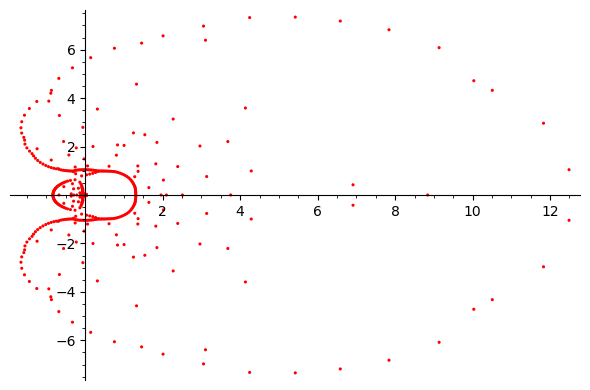

In [4]:
import pickle
rfile = open('/Users/barrybrent/16sept22no3.txt','rb') #dagger Euler exponents polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
for k in [97..97]:
    print("=====================================================================================")
    print("exponent: ",s[k][0])
    points=[]
    poly=s[k][1]
    poly=R(poly)
    pr=poly.roots(CC)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        print("j: ",j)
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        roots=roots+[rootpair]
       
    rootplot=list_plot(roots,color='red',size=5)
    show(rootplot)

exponent:  1


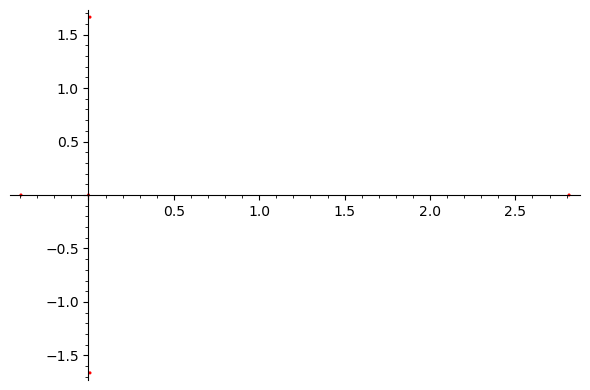

exponent:  2


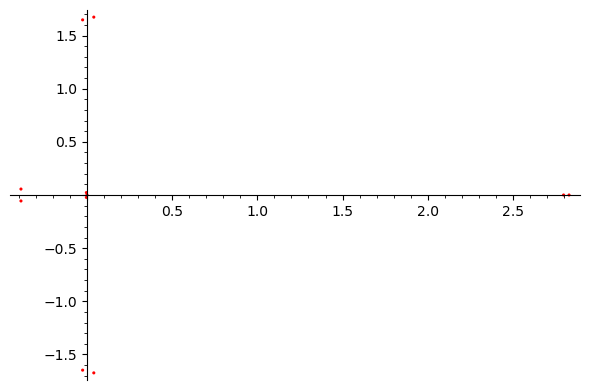

exponent:  3


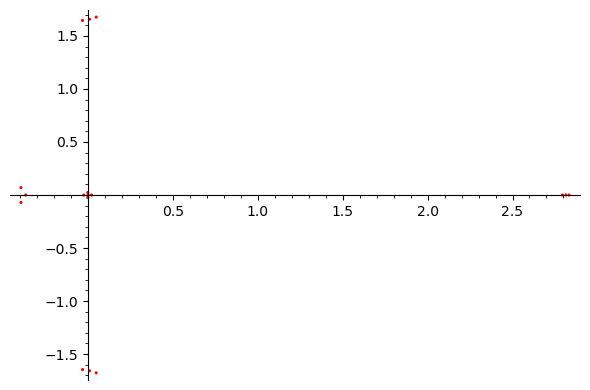

exponent:  4


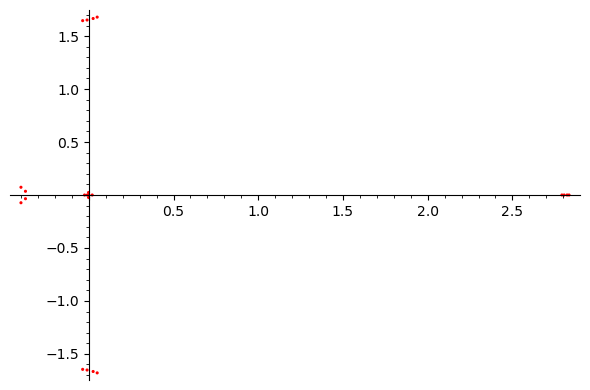

exponent:  5


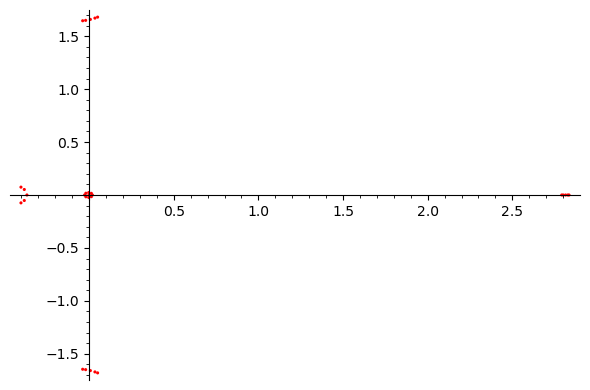

exponent:  6


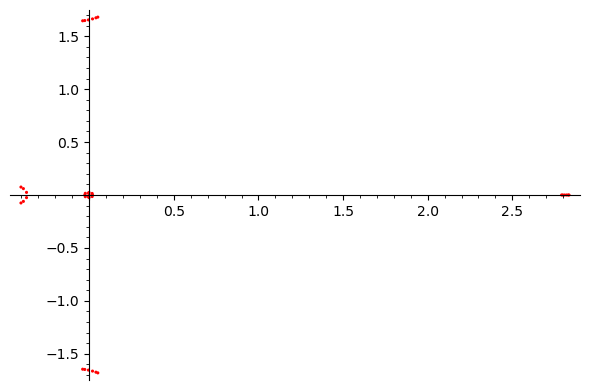

exponent:  7


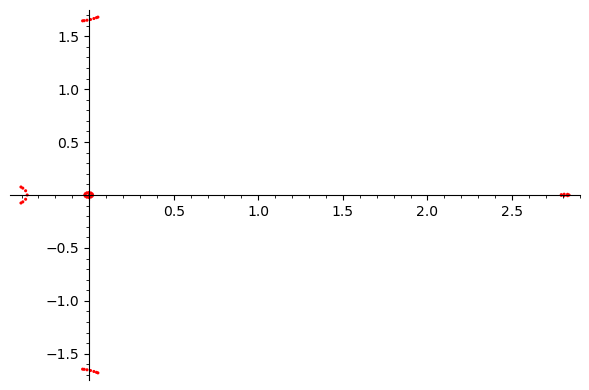

exponent:  8


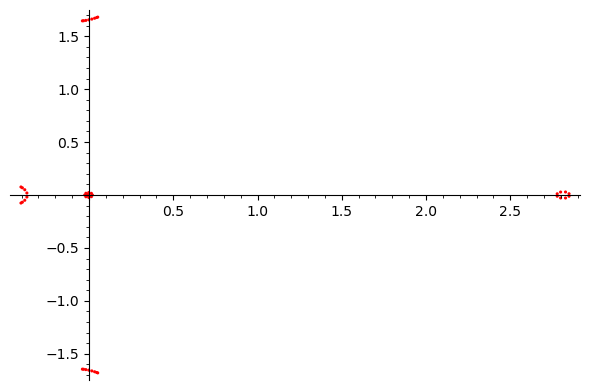

exponent:  9


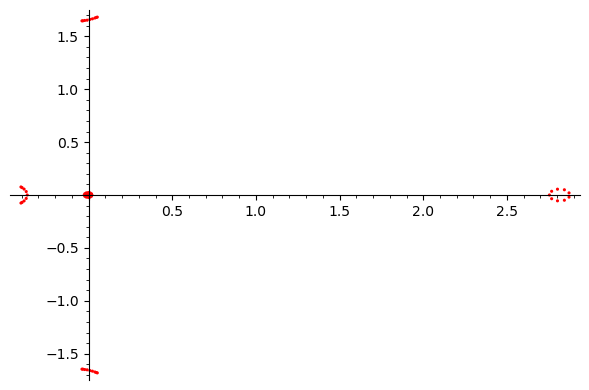

exponent:  10


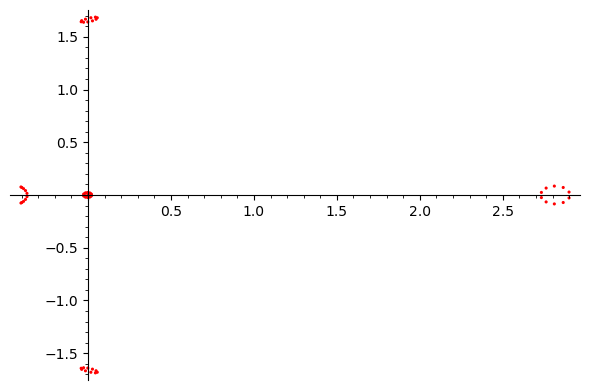

exponent:  11


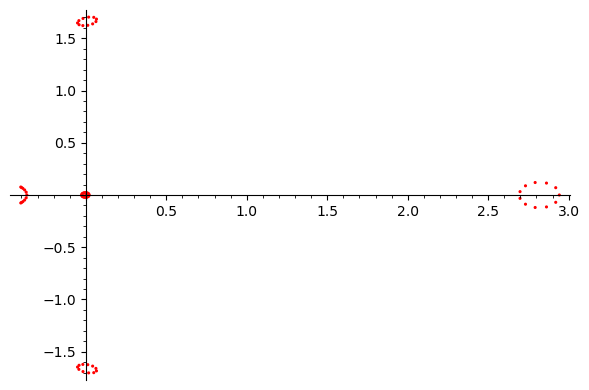

exponent:  12


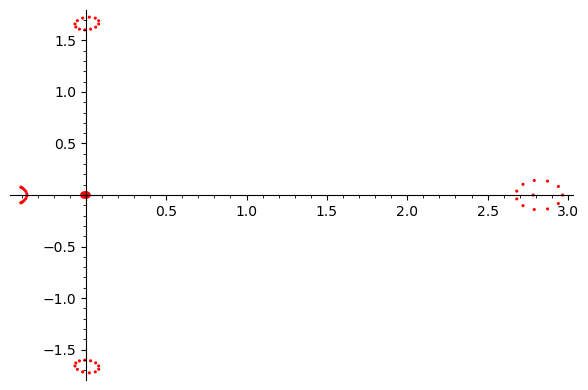

exponent:  13


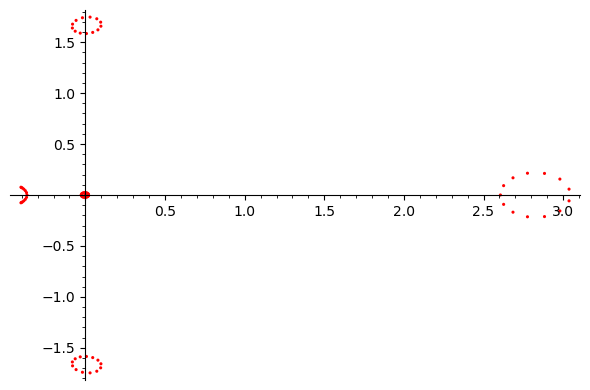

exponent:  14


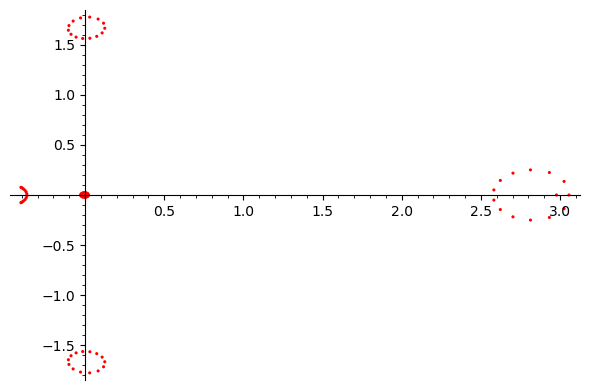

exponent:  15


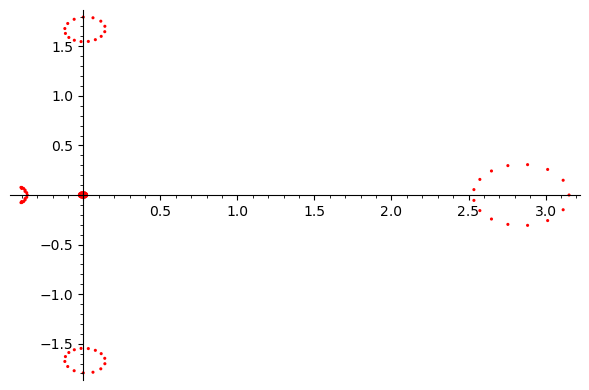

exponent:  16


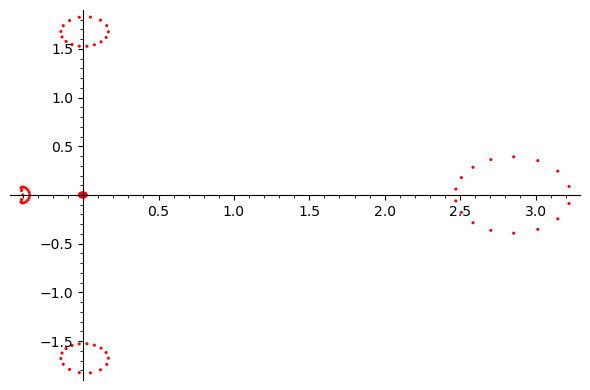

exponent:  17


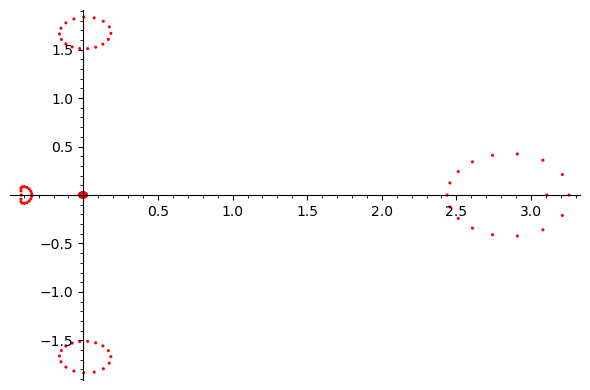

exponent:  18


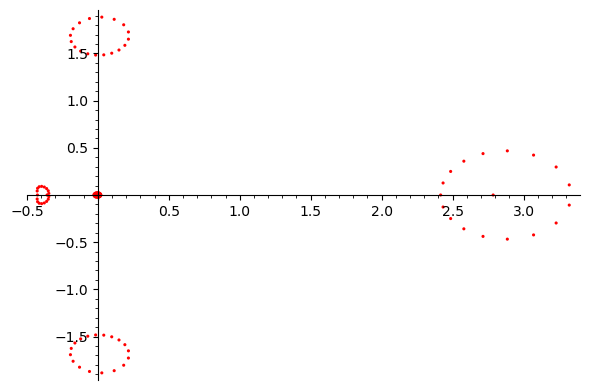

exponent:  19


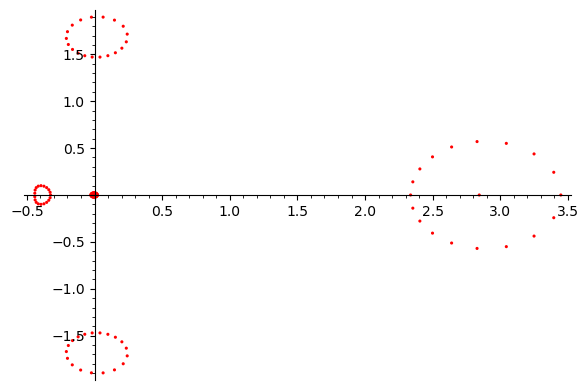

exponent:  20


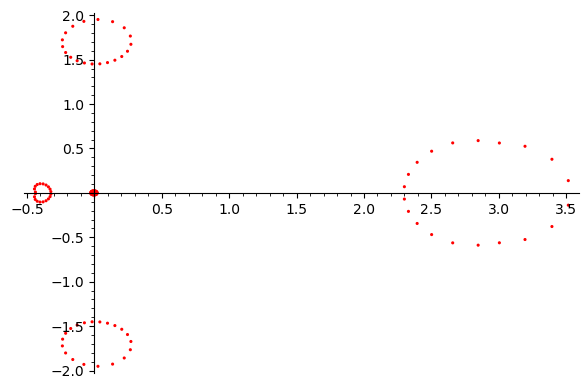

exponent:  21


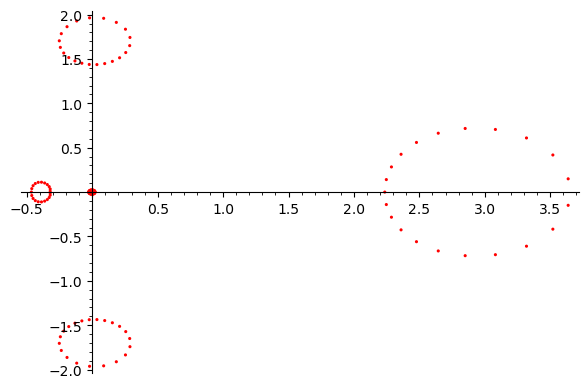

exponent:  22


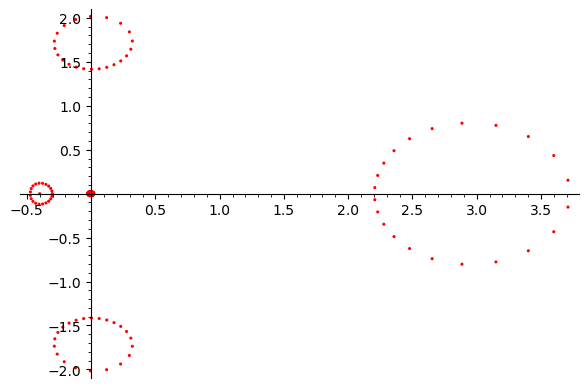

exponent:  23


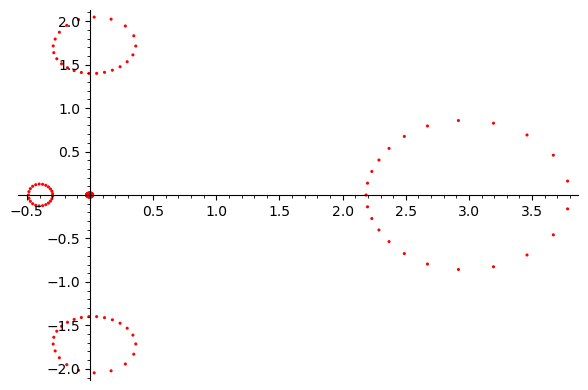

exponent:  24


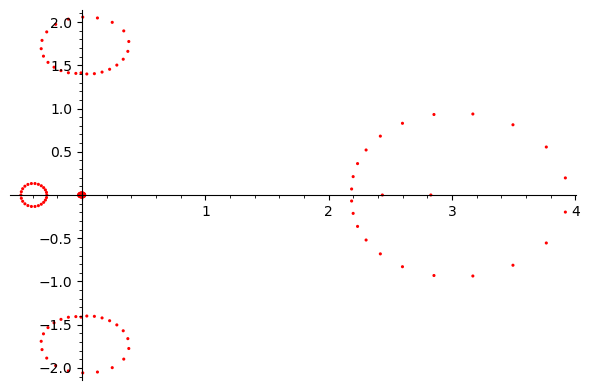

exponent:  25


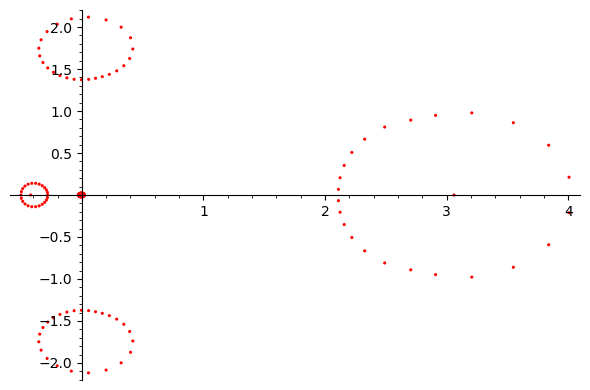

exponent:  26


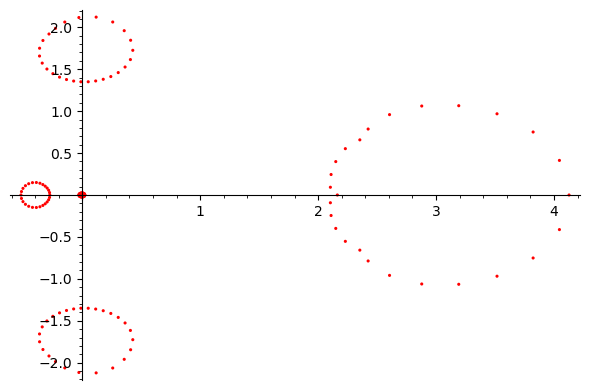

exponent:  27


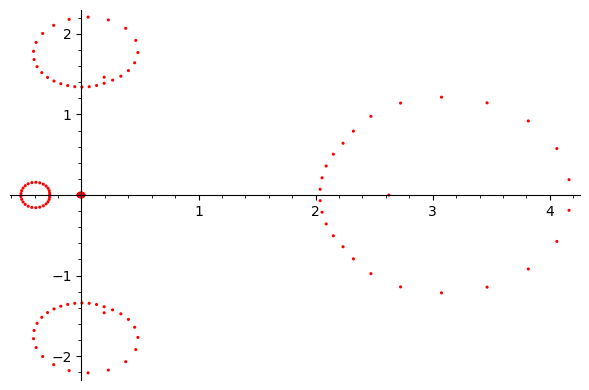

exponent:  28


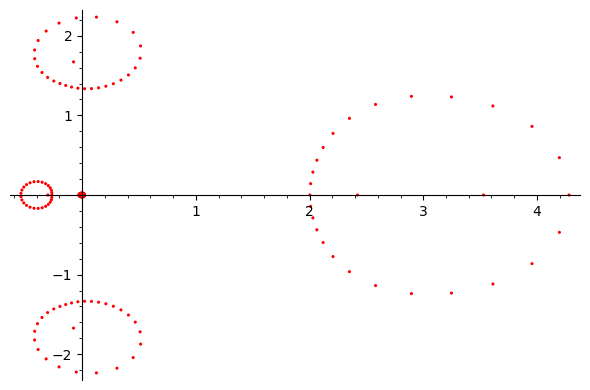

exponent:  29


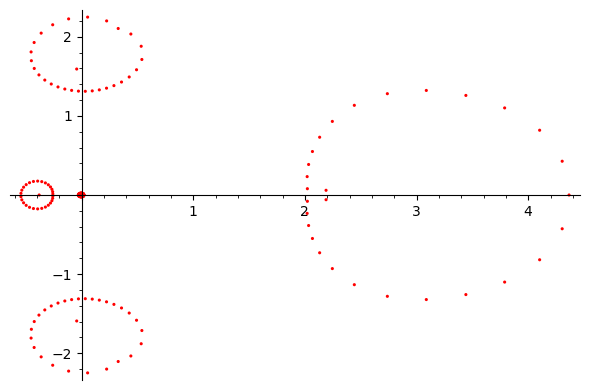

exponent:  30


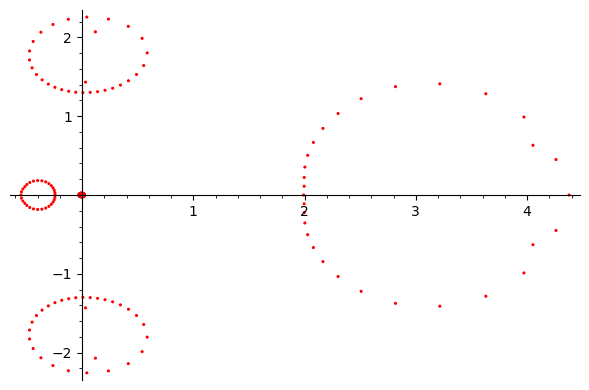

exponent:  31


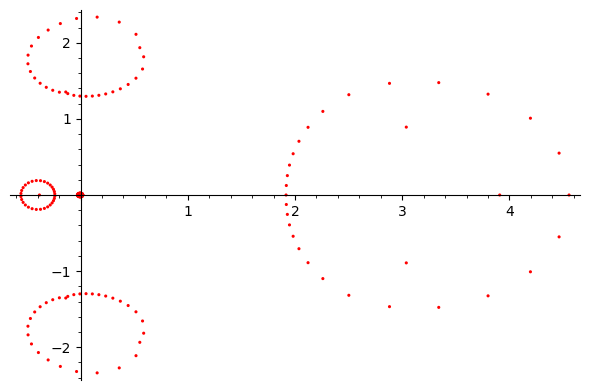

exponent:  32


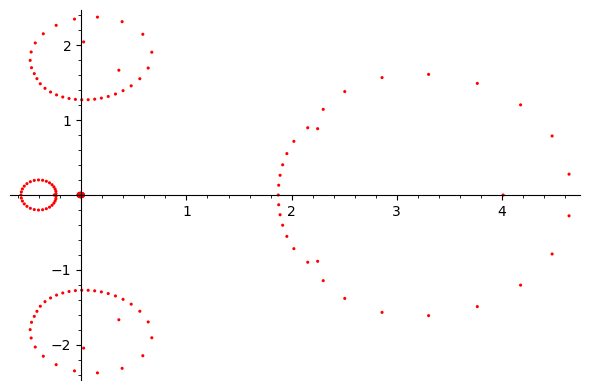

exponent:  33


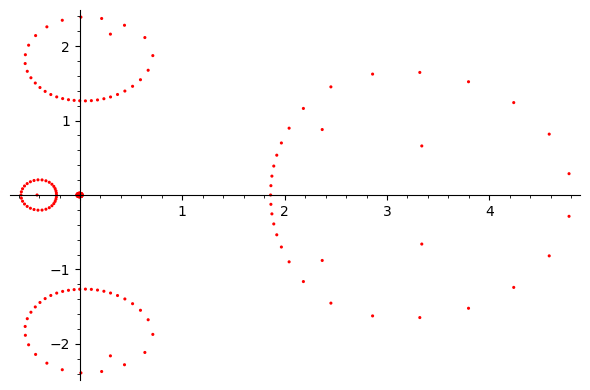

exponent:  34


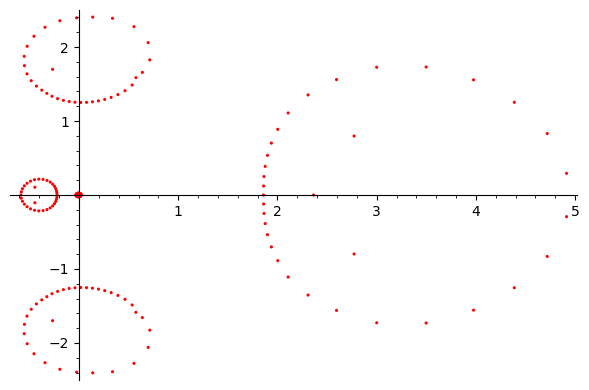

exponent:  35


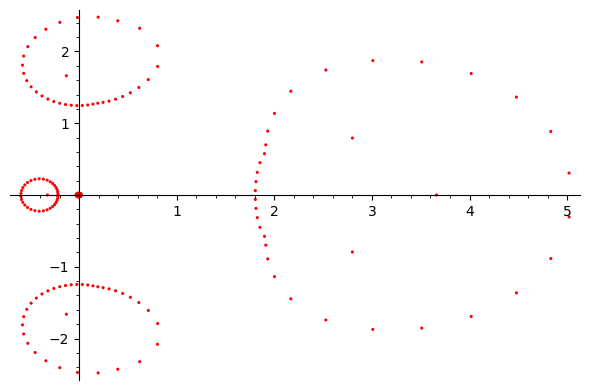

exponent:  36


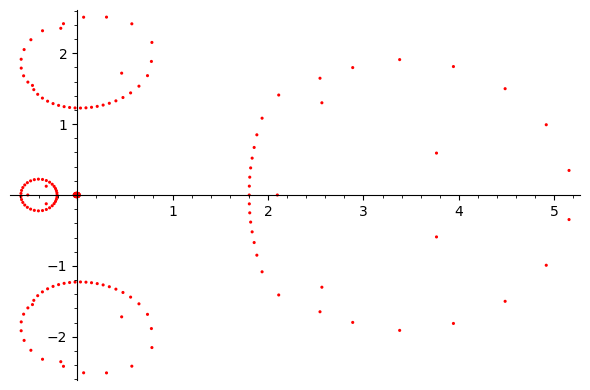

exponent:  37


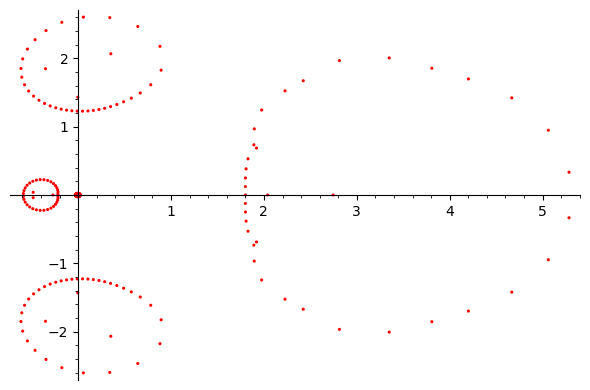

exponent:  38


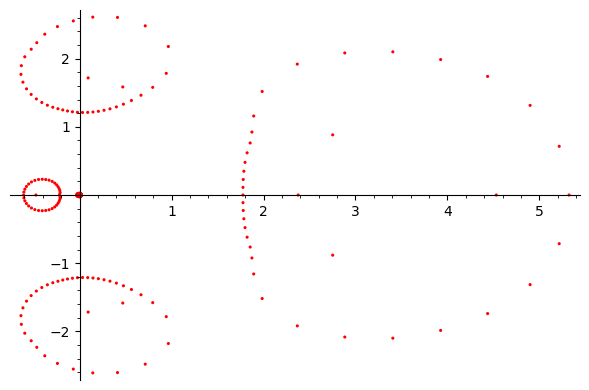

exponent:  39


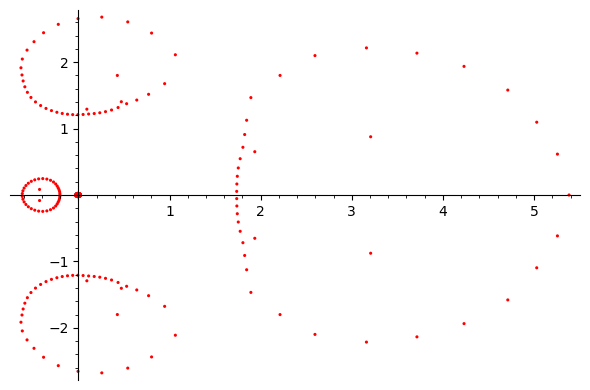

exponent:  40


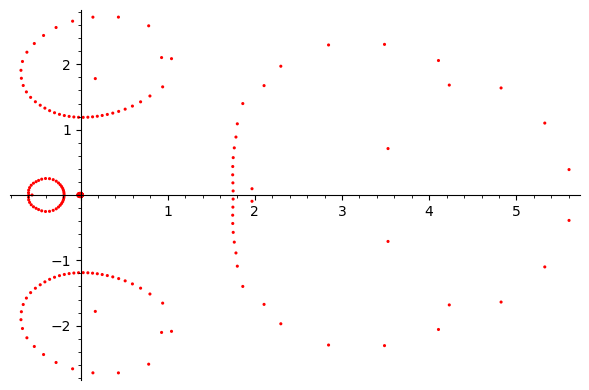

exponent:  41


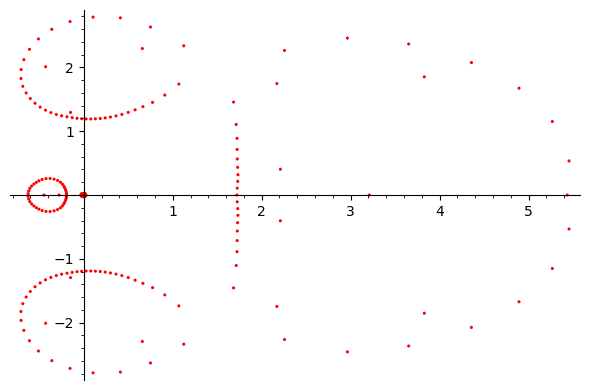

exponent:  42


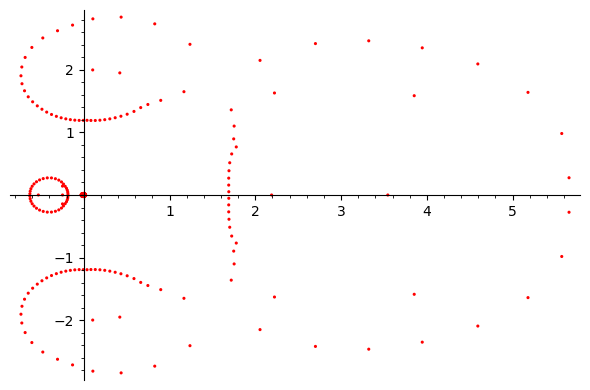

exponent:  43


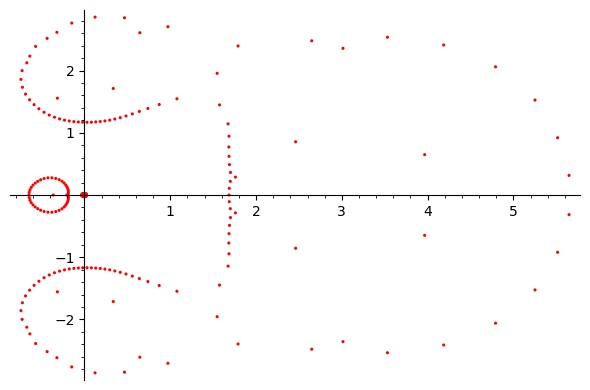

exponent:  44


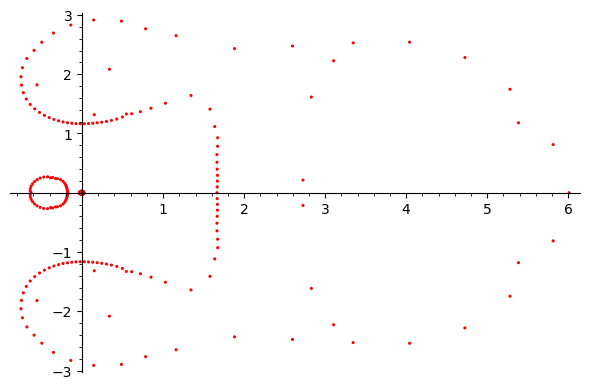

exponent:  45


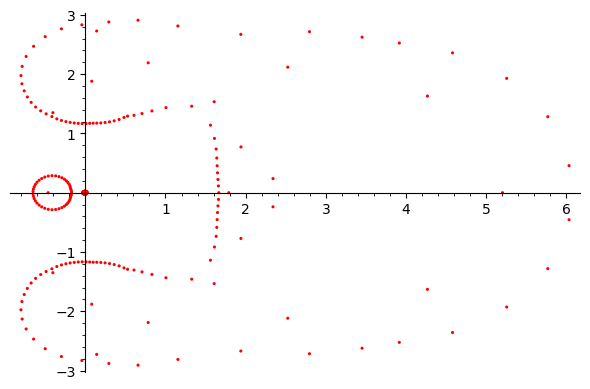

exponent:  46


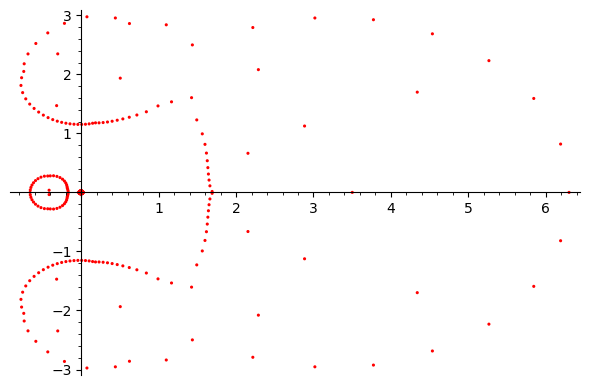

exponent:  47


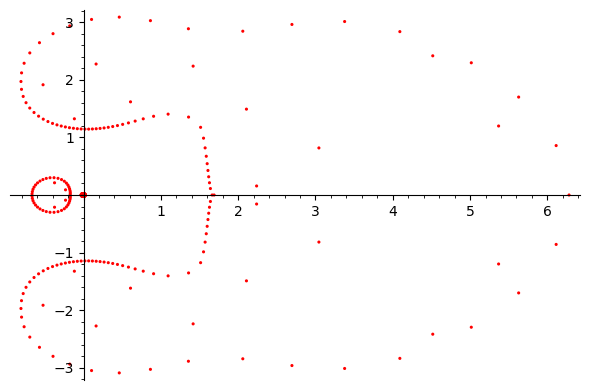

exponent:  48


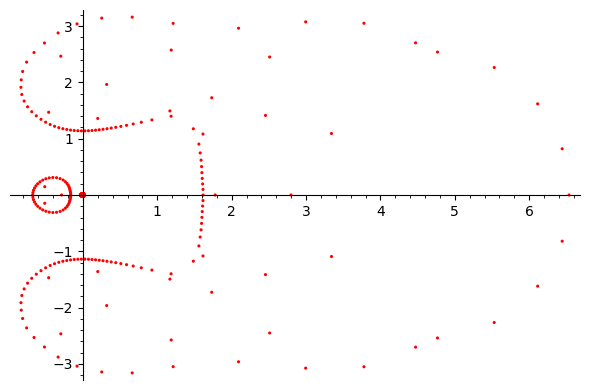

exponent:  49


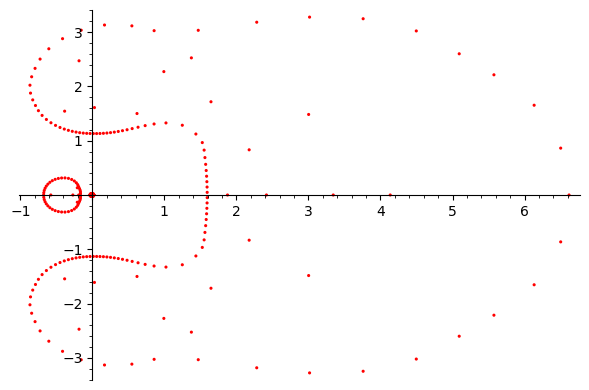

exponent:  50


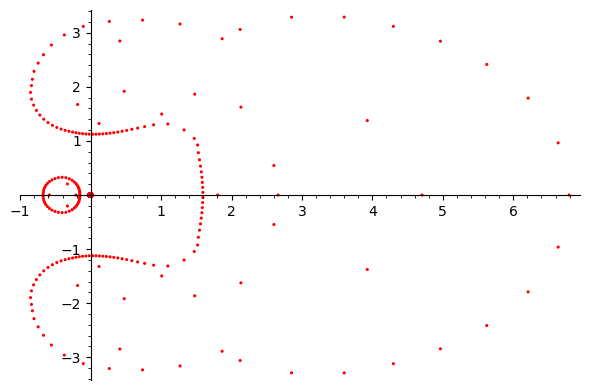

exponent:  51


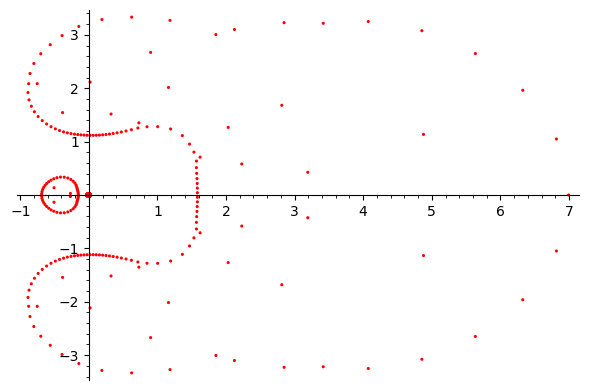

exponent:  52


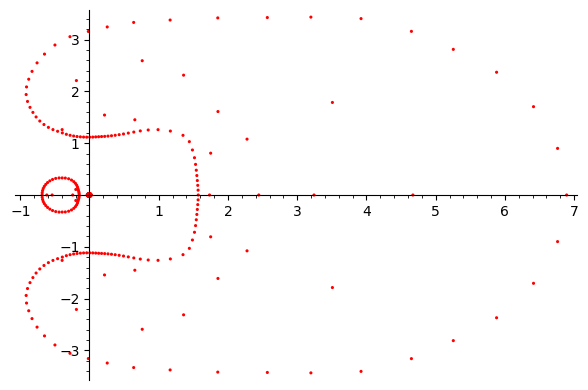

exponent:  53


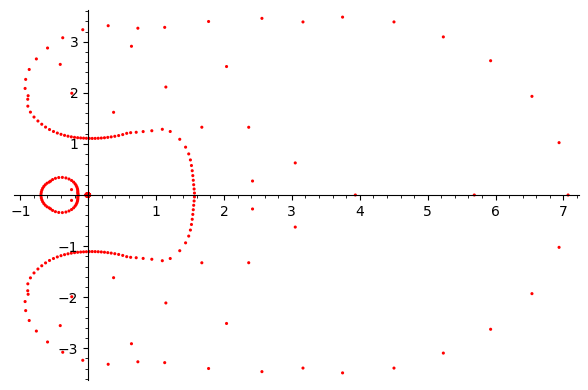

exponent:  54


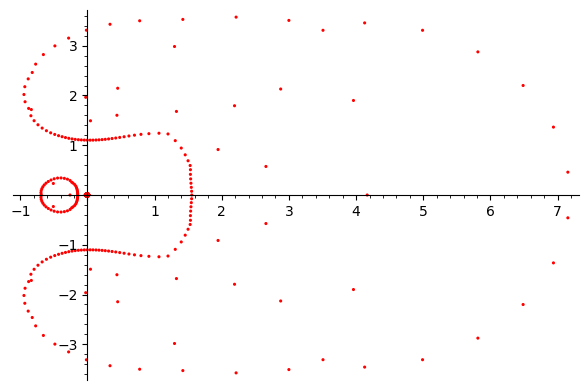

exponent:  55


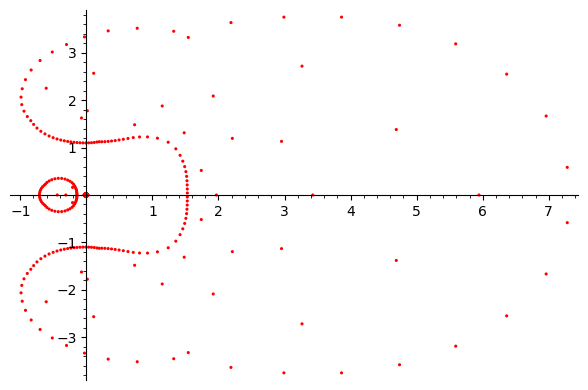

exponent:  56


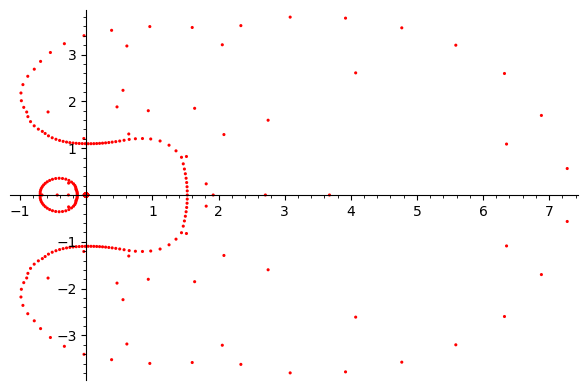

exponent:  57


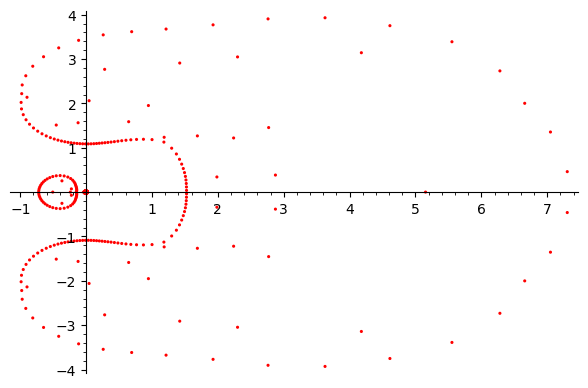

exponent:  58


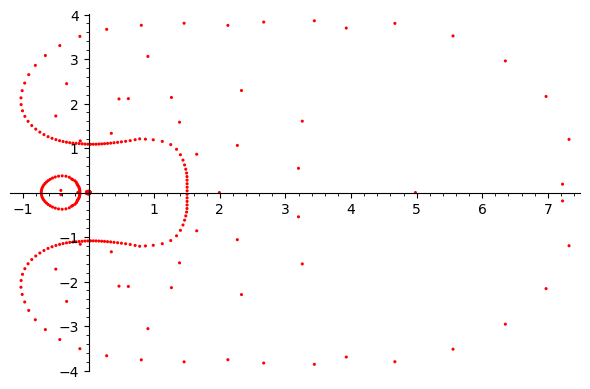

exponent:  59


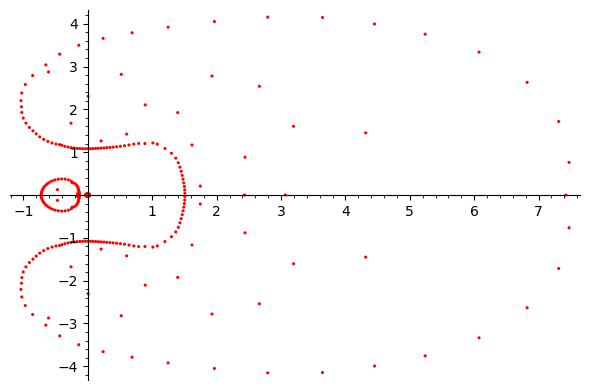

exponent:  60


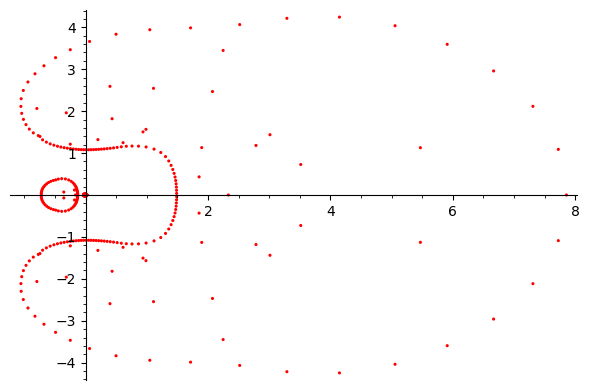

exponent:  61


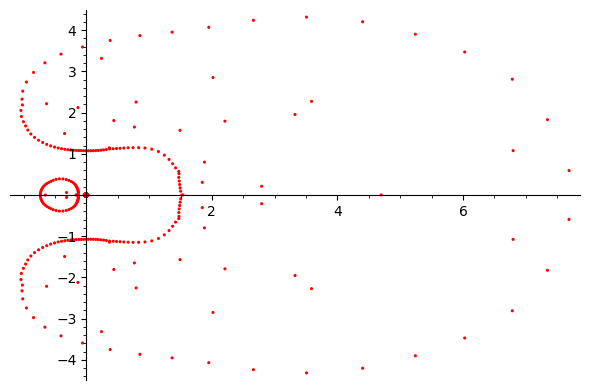

exponent:  62


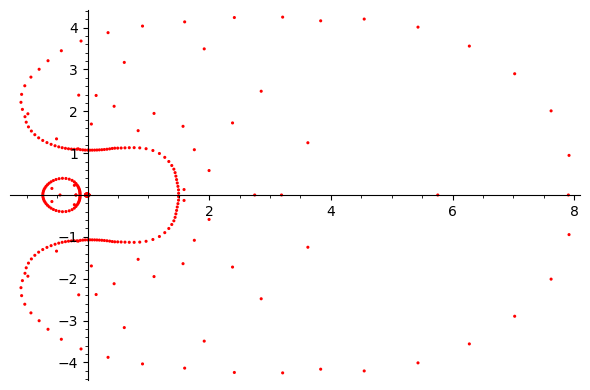

exponent:  63


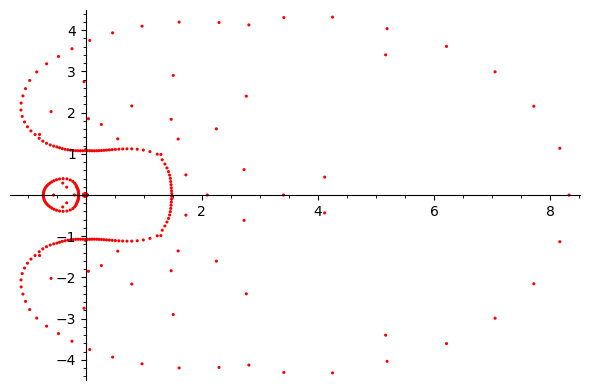

exponent:  64


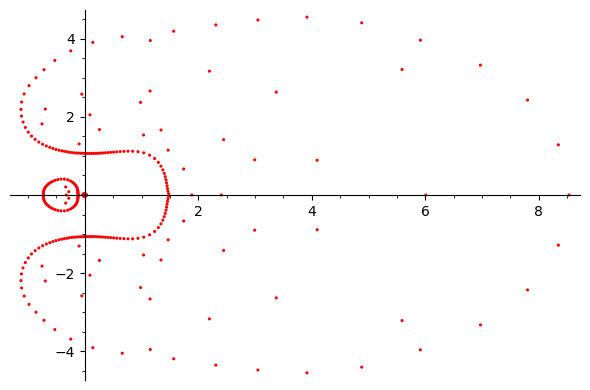

exponent:  65


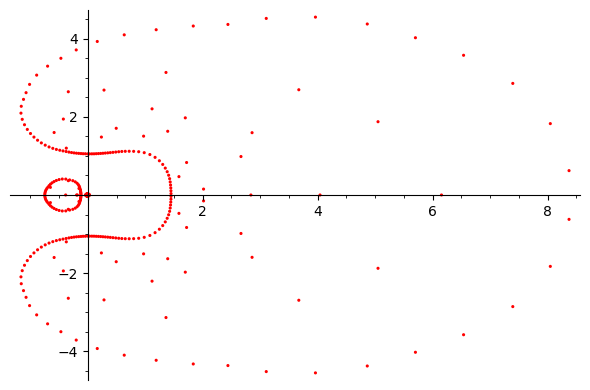

exponent:  66


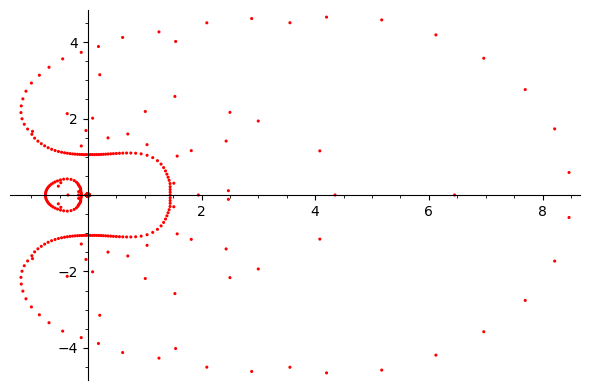

exponent:  67


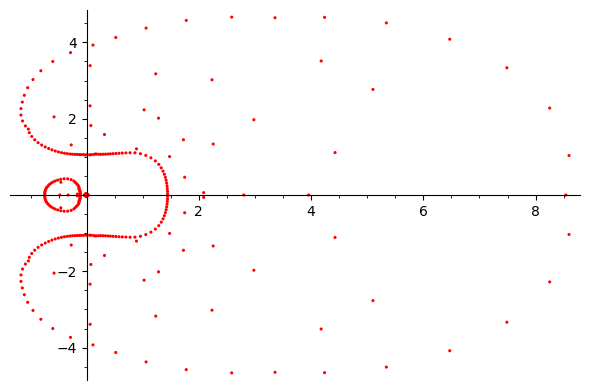

exponent:  68


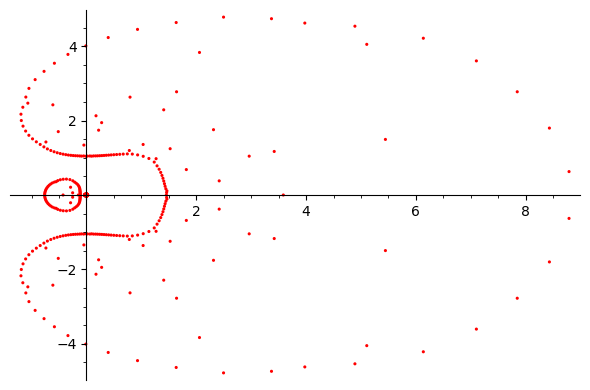

exponent:  69


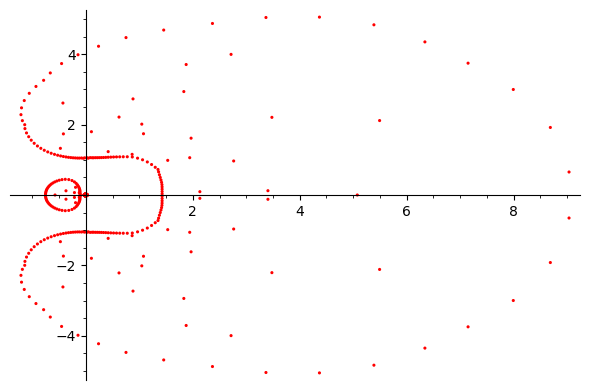

exponent:  70


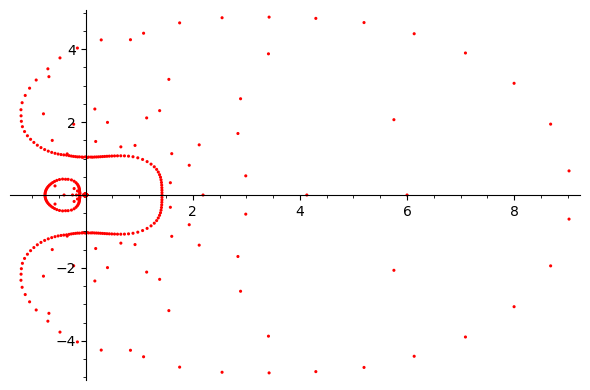

exponent:  71


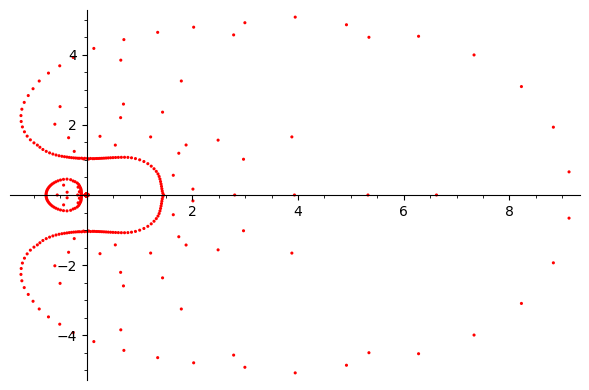

exponent:  72


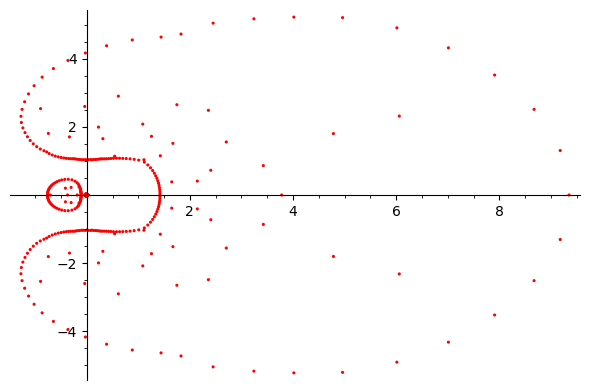

exponent:  73


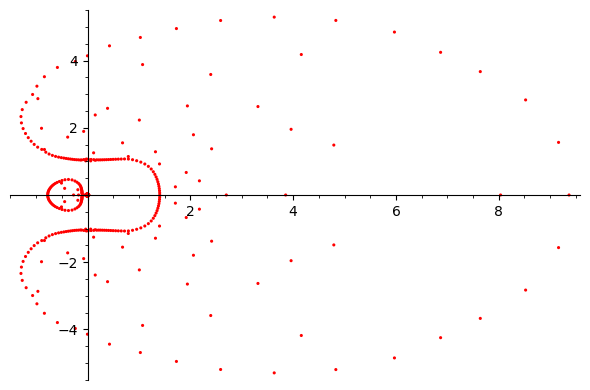

exponent:  74


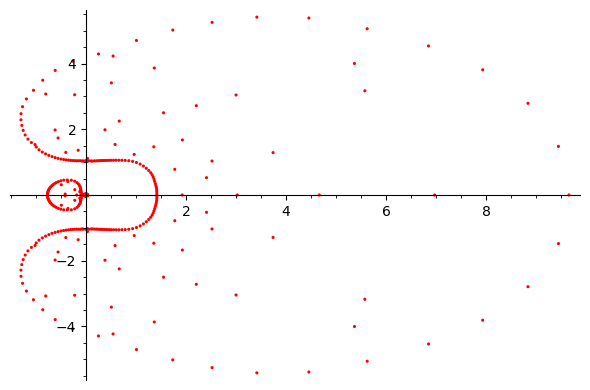

exponent:  75


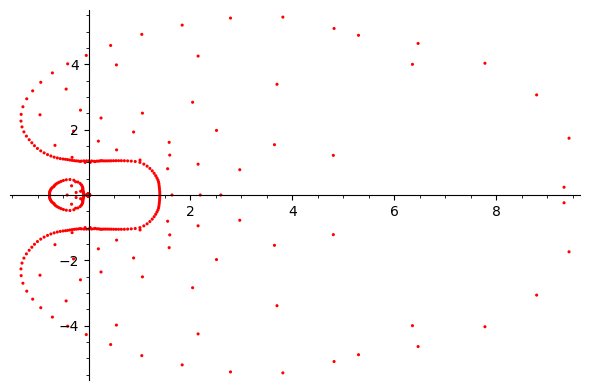

exponent:  76


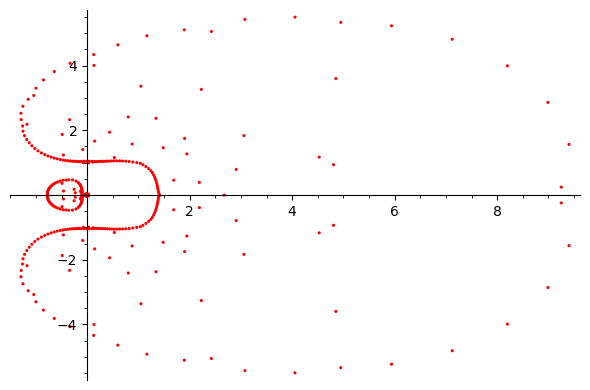

exponent:  77


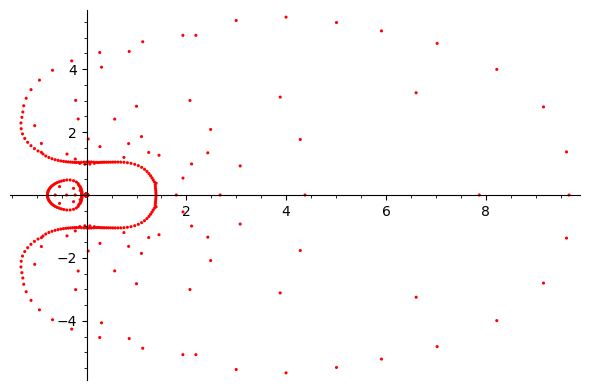

exponent:  78


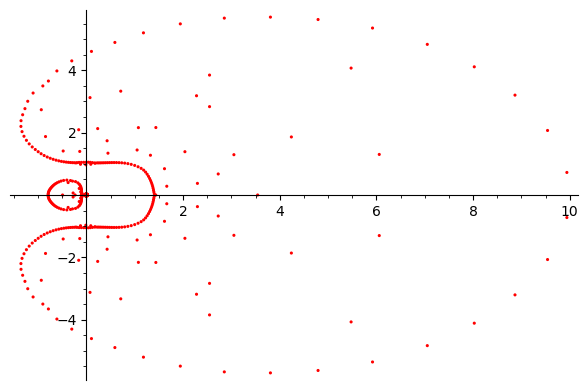

exponent:  79


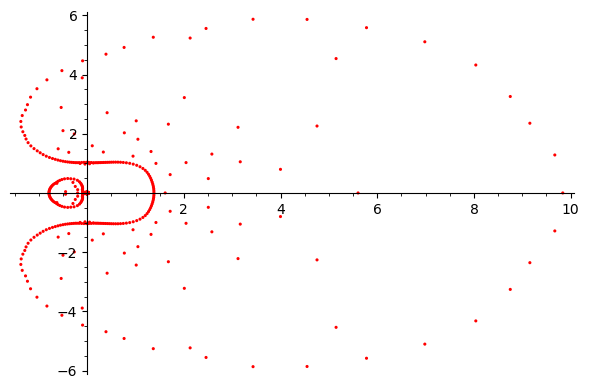

exponent:  80


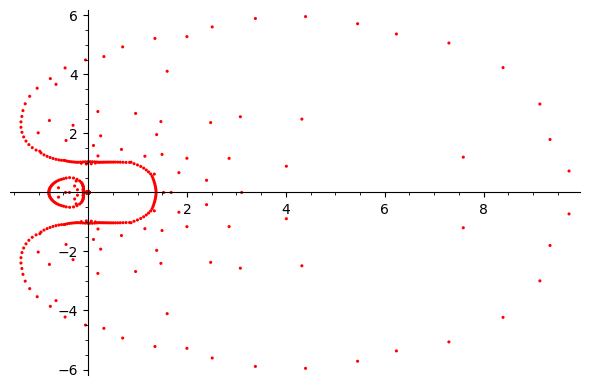

exponent:  81


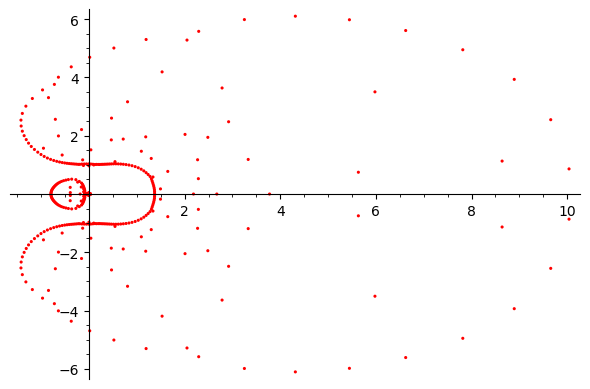

exponent:  82


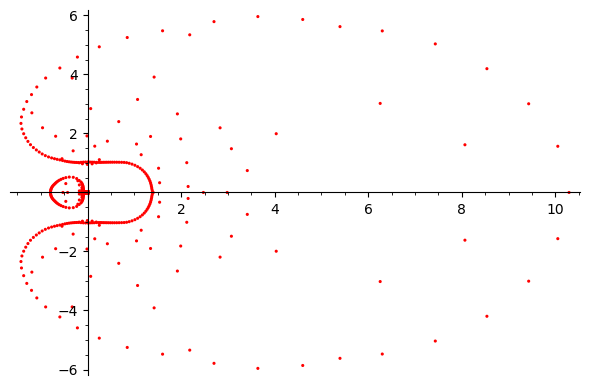

exponent:  83


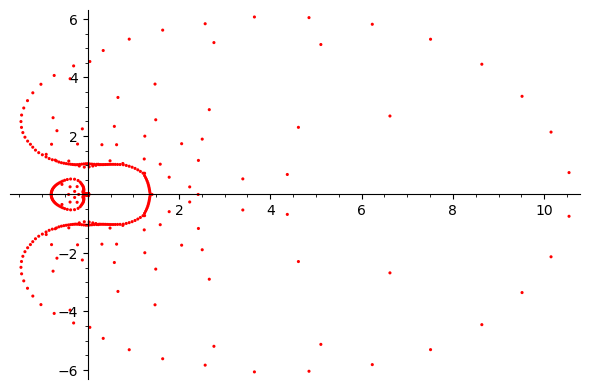

exponent:  84


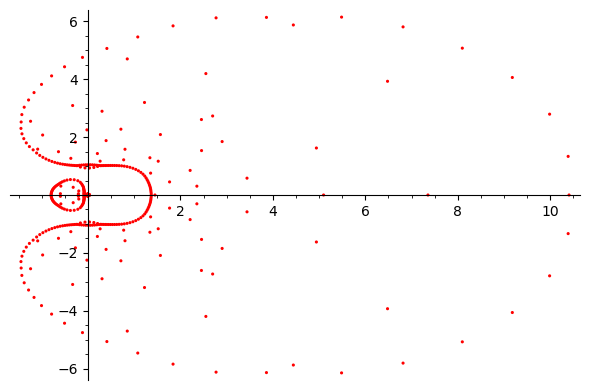

exponent:  85


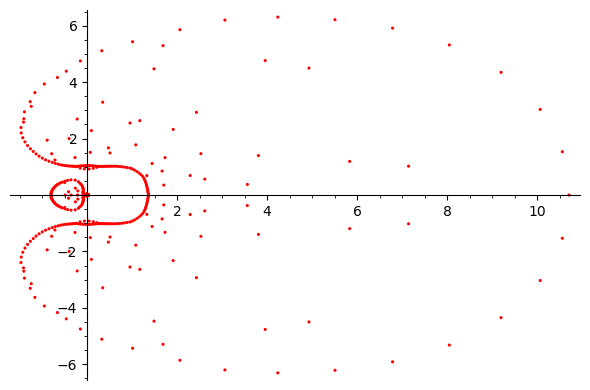

exponent:  86


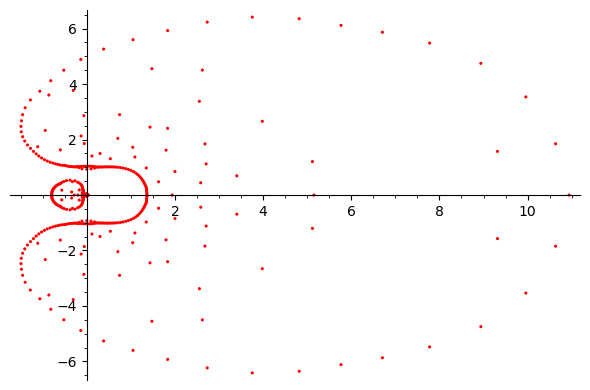

exponent:  87


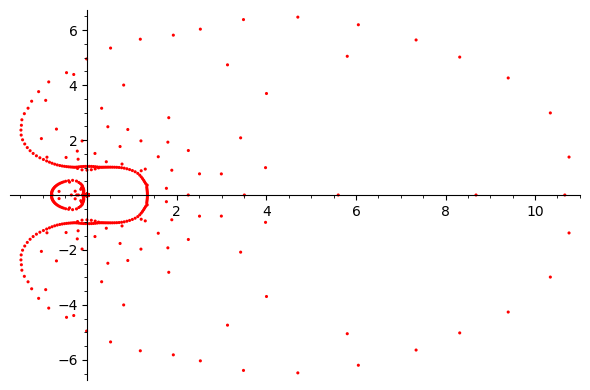

exponent:  88


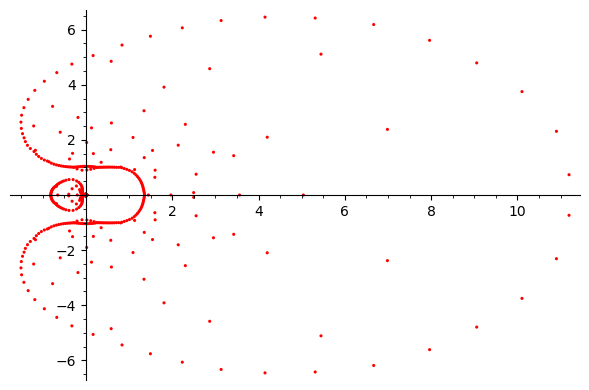

exponent:  89


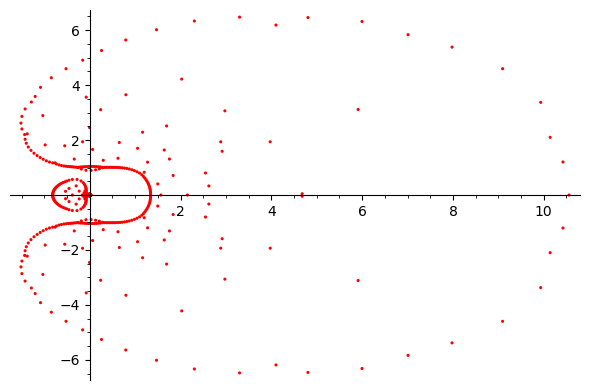

exponent:  90


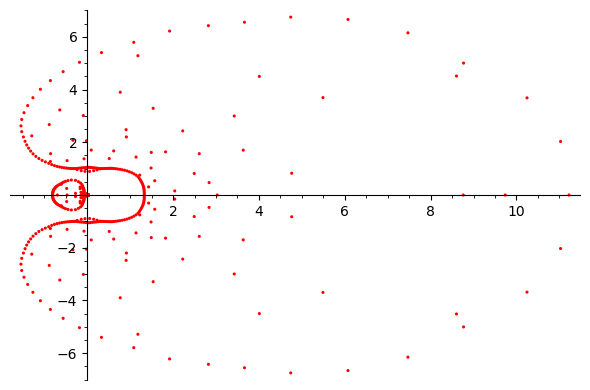

exponent:  91


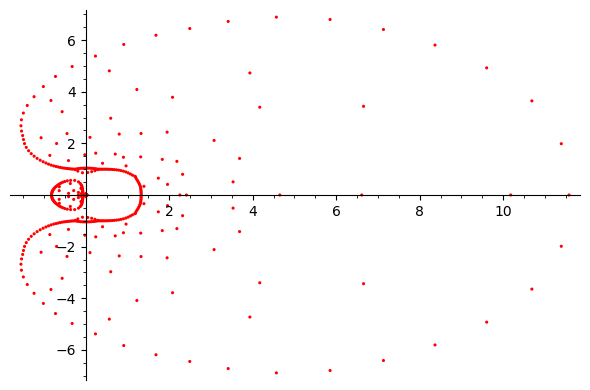

exponent:  92


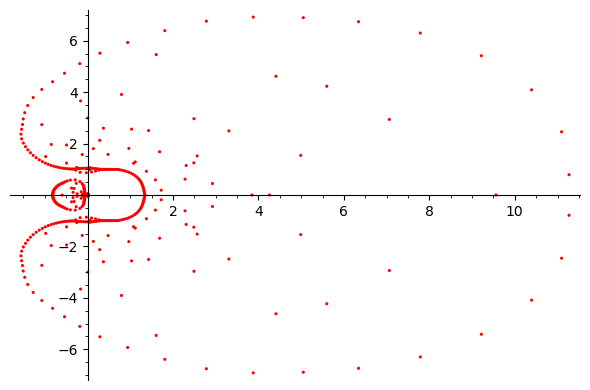

exponent:  93


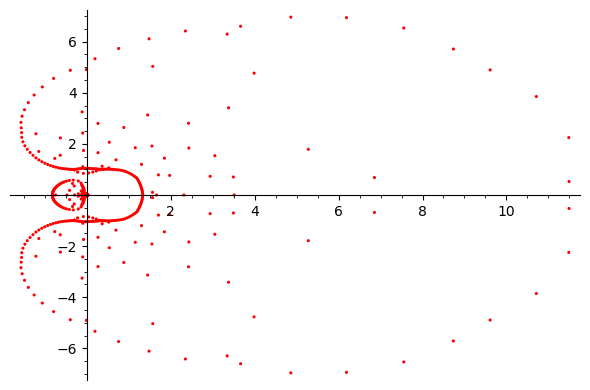

exponent:  94


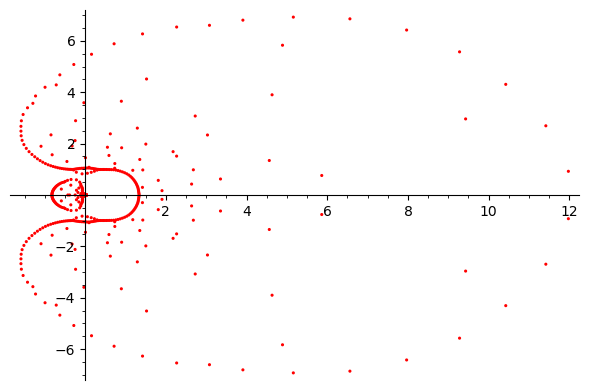

exponent:  95


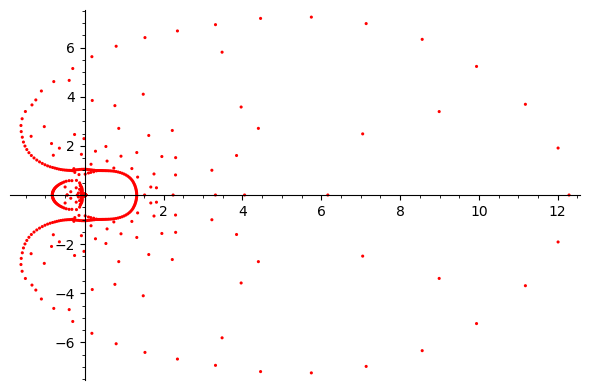

exponent:  96


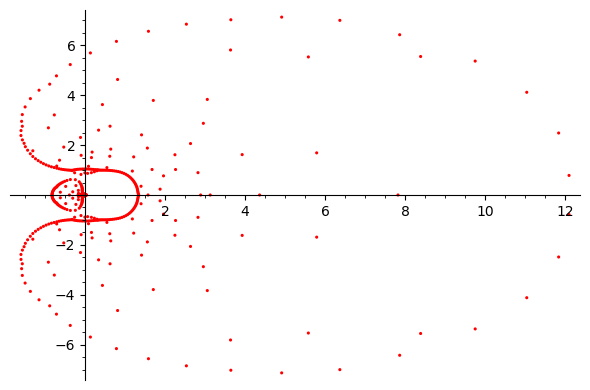

exponent:  97


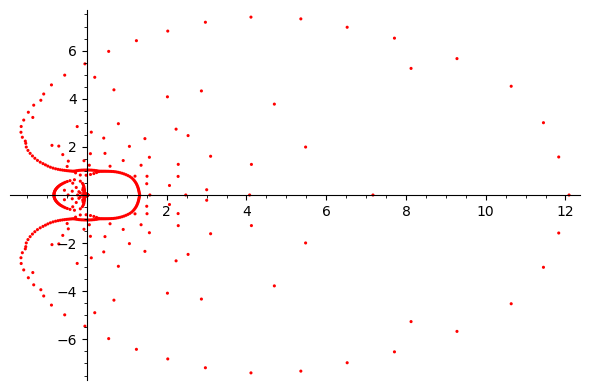

exponent:  98


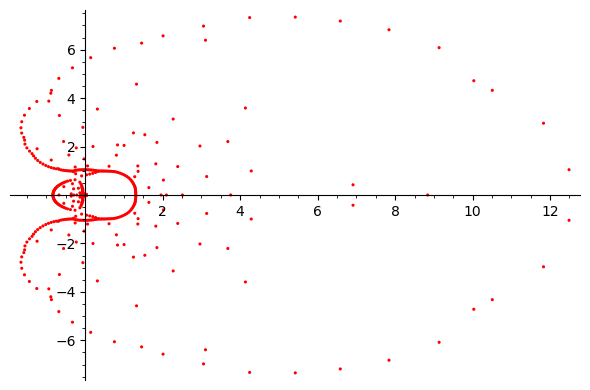

In [6]:
import pickle
rfile = open('/Users/barrybrent/16sept22no3.txt','rb') #dagger Euler exponents polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
for k in [0..97]:
    print("=====================================================================================")
    print("exponent: ",s[k][0])
    points=[]
    poly=s[k][1]
    poly=R(poly)
    pr=poly.roots(CC)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        roots=roots+[rootpair]
       
    rootplot=list_plot(roots,color='red',size=5)
    show(rootplot)